In [1]:
"""
Transform accumulated changes from fMRI layers into durations (s) using
multiclass SVM
"""

'\nTransform accumulated changes from fMRI layers into durations (s) using\nmulticlass SVM\n'

# IMPORT LIBS AND DATA 

In [1]:
from sklearn.svm import SVR
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import scipy.io as sio
import scipy.stats as stats
from scipy import signal
import os.path as op
import os
from sklearn.base import clone
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import chi2
import glob
from time import time
import statistics

#Device configuration
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
#from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import scipy.stats as stats
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

outdir = 'D:\\ERICK\\MD\\prediction_data\\'
datadir = 'D:\\ERICK\\MD\\'
load_file = op.join(datadir, 'master_dataset.csv')
data = pd.read_csv(load_file)

In [108]:
# data = data.loc[(data['rawSubjID']!=41) & (data['rawSubjID']!=45)]
np.sum(np.isnan(data['humanBias']))

0

In [10]:
import warnings
warnings.filterwarnings("ignore")
task = 'bias'
region = 'rGlasser'
n_nodes = 64620

# load data
durations = [8, 12, 16, 20, 24]
videoTypes = [0, 1] #office, city
rooth = op.join(datadir, 'extracted_voxels')
excluded = [4, 10, 12, 41, 45] #sujeito 4 tem muitos nan, ainda não sei porque
load_file = op.join(datadir, 'master_dataset.csv')
df = pd.read_csv(load_file)

def standardize(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    standardized_data = (data - mean) / std
    return standardized_data

fc_data = [] 
outcome = []
for sub in range(4, 46):
    print(sub)
    if sub in excluded:
        print('skipping subject')
        continue
    for run in range(1, 5):
        if not task=='videoType':
            for trial in range(1, 21):
                subset = df.loc[(df['rawSubjID'] == sub) & (df['run'] == run) & (df['trial'] == trial)]
#                 print(subset)
                if len(subset)!=0:
                    hr = float(subset['humanReport'].values)
                    bias = float(subset['humanBias'].values)
                    fcMatFile = op.join(rooth, str(sub), 'FC', 'rGlasserFC_run'+str(run)+'_trial'+str(trial)+'.mat')
                    if op.isfile(fcMatFile):
                        print(hr, fcMatFile)
                        outcome.append(bias)
                        data = sio.loadmat(fcMatFile)
                        fdata = data['fc']
                        print(fdata)
#                             fdata = bandpass_filter(data['avg_data'], 0.008, 0.09, 1.25)
                        fc_data.append(fdata)
                        del data
                else:
                    print(f'Inexistent data for subj {sub}, run = {run}, trial = {trial}')
                    continue

        if task=='videoType':
            for vid in videoTypes:
                num_components = -1
                run_data = []
                for trial in range(1, 21):
                    subset = df.loc[(df['rawSubjID'] == sub) & (df['run'] == run) & (df['trial'] == trial)]
    #                 print(subset)
                    try:
                        hr = float(subset['humanReport'].values)
                        if hr.is_integer():
                            hr = int(hr)
                        else:
                            hr = hr
                        vt = int(subset['isCity'].values)
                        if not region=='rGlasser':
                            tsMatFile = op.join(tsdir, str(sub), 'time_series', region+'TS_run'+str(run)+'_trial'+str(trial)+'_dur='+str(hr)+'.mat')
#                             print(tsMatFile)
                        else:
                            tsMatFile = op.join(tsdir, str(sub), 'rGlasserTS_run'+str(run)+'_trial'+str(trial)+'_dur='+str(hr)+'.mat')
#                             print(tsMatFile)
                        if op.isfile(tsMatFile) and subset['isCity'].values==vid:
                            print(tsMatFile)
                            outcome.append(vt)
                            data = sio.loadmat(tsMatFile)
                            fdata = data['avg_data'][~np.isnan(data['avg_data']).any(axis=1)]
#                             fdata = bandpass_filter(fdata, 0.008, 0.09, 1.25) #faz sentido?
                            run_data.append(fdata)
#                             print(data['avg_data'].shape)
    #                         print(dur_data)
                            del data
        
                    except:
                        continue
                    
                try:
                    run_data = np.concatenate(run_data, axis=1)
                    print(run_data.shape)
                    ts_data.append(run_data)
                except:
                    print(f'Inexistent data for subj {sub}, run = {run}, duration = {dur}')
     
fc_data = np.concatenate(fc_data, axis=1)
fc_data = standardize(fc_data)
fc_data = fc_data.reshape(-1, n_edges)
# fc_data = torch.tensor(fc_data, dtype=torch.float32) 
if task=='verDur' or task=='bias':
    outcome = standardize(outcome)
    outcome = outcome.reshape(len(outcome), 1)
## final shape: [trials, region, ts]

4
skipping subject
5
9.5 D:\ERICK\MD\extracted_voxels\5\FC\rGlasserFC_run1_trial1.mat
[[0.74107675]
 [0.84307305]
 [0.74465768]
 ...
 [0.47012974]
 [0.35531613]
 [0.40506066]]
11.0 D:\ERICK\MD\extracted_voxels\5\FC\rGlasserFC_run1_trial2.mat
[[0.95353689]
 [0.77709948]
 [0.82183403]
 ...
 [0.35339199]
 [0.32571575]
 [0.64499175]]
9.4 D:\ERICK\MD\extracted_voxels\5\FC\rGlasserFC_run1_trial3.mat
[[0.78766729]
 [0.88747719]
 [0.75616465]
 ...
 [0.04743079]
 [0.63653092]
 [0.64549968]]
16.7 D:\ERICK\MD\extracted_voxels\5\FC\rGlasserFC_run1_trial4.mat
[[ 0.93314345]
 [ 0.95557322]
 [ 0.89202851]
 ...
 [-0.12976203]
 [ 0.12354561]
 [-0.03253805]]
15.3 D:\ERICK\MD\extracted_voxels\5\FC\rGlasserFC_run1_trial5.mat
[[0.69111408]
 [0.81531606]
 [0.53407134]
 ...
 [0.17359649]
 [0.38059761]
 [0.34535448]]
11.8 D:\ERICK\MD\extracted_voxels\5\FC\rGlasserFC_run1_trial6.mat
[[0.88161989]
 [0.82251959]
 [0.83666283]
 ...
 [0.18490089]
 [0.29245797]
 [0.25511273]]
14.8 D:\ERICK\MD\extracted_voxels\5\FC\

9.6 D:\ERICK\MD\extracted_voxels\6\FC\rGlasserFC_run2_trial2.mat
[[0.90756764]
 [0.96100735]
 [0.92494436]
 ...
 [0.09051841]
 [0.47769011]
 [0.47157095]]
12.9 D:\ERICK\MD\extracted_voxels\6\FC\rGlasserFC_run2_trial3.mat
[[0.62181248]
 [0.77256557]
 [0.69409764]
 ...
 [0.04495444]
 [0.56919348]
 [0.53903235]]
11.2 D:\ERICK\MD\extracted_voxels\6\FC\rGlasserFC_run2_trial4.mat
[[0.80921449]
 [0.7840774 ]
 [0.82828257]
 ...
 [0.47230303]
 [0.42647227]
 [0.45523664]]
16.0 D:\ERICK\MD\extracted_voxels\6\FC\rGlasserFC_run2_trial5.mat
[[ 0.89379275]
 [ 0.92153771]
 [ 0.91991117]
 ...
 [ 0.18215252]
 [-0.11135521]
 [ 0.27665307]]
11.3 D:\ERICK\MD\extracted_voxels\6\FC\rGlasserFC_run2_trial6.mat
[[ 0.61404176]
 [ 0.62263786]
 [ 0.72351705]
 ...
 [-0.08764821]
 [ 0.48074089]
 [ 0.27348659]]
22.8 D:\ERICK\MD\extracted_voxels\6\FC\rGlasserFC_run2_trial7.mat
[[0.9191531 ]
 [0.89357996]
 [0.94569526]
 ...
 [0.24322042]
 [0.13810624]
 [0.45733608]]
19.8 D:\ERICK\MD\extracted_voxels\6\FC\rGlasserFC_run

[[0.91519781]
 [0.94757375]
 [0.90843827]
 ...
 [0.06090476]
 [0.37110315]
 [0.24471352]]
5.4 D:\ERICK\MD\extracted_voxels\7\FC\rGlasserFC_run2_trial3.mat
[[0.94460299]
 [0.90790313]
 [0.93138907]
 ...
 [0.56680298]
 [0.26047573]
 [0.5103603 ]]
18.6 D:\ERICK\MD\extracted_voxels\7\FC\rGlasserFC_run2_trial4.mat
[[0.97710821]
 [0.98418455]
 [0.985612  ]
 ...
 [0.03747745]
 [0.28832313]
 [0.36257276]]
8.1 D:\ERICK\MD\extracted_voxels\7\FC\rGlasserFC_run2_trial5.mat
[[0.89259473]
 [0.97521232]
 [0.93294548]
 ...
 [0.37008353]
 [0.0623209 ]
 [0.426529  ]]
18.7 D:\ERICK\MD\extracted_voxels\7\FC\rGlasserFC_run2_trial6.mat
[[ 0.82218191]
 [ 0.92960927]
 [ 0.87049261]
 ...
 [-0.10455939]
 [ 0.24334881]
 [ 0.37807374]]
14.0 D:\ERICK\MD\extracted_voxels\7\FC\rGlasserFC_run2_trial7.mat
[[0.76427125]
 [0.89079966]
 [0.93486974]
 ...
 [0.24572873]
 [0.5508102 ]
 [0.45306429]]
14.8 D:\ERICK\MD\extracted_voxels\7\FC\rGlasserFC_run2_trial8.mat
[[0.87476138]
 [0.94399428]
 [0.95458143]
 ...
 [0.39707584]

[[ 0.85882795]
 [ 0.92158096]
 [ 0.92079077]
 ...
 [ 0.62898732]
 [ 0.55111054]
 [-0.25272622]]
6.9 D:\ERICK\MD\extracted_voxels\11\FC\rGlasserFC_run1_trial10.mat
[[0.97055169]
 [0.98056082]
 [0.96546856]
 ...
 [0.22707829]
 [0.59302515]
 [0.56954478]]
9.5 D:\ERICK\MD\extracted_voxels\11\FC\rGlasserFC_run1_trial11.mat
[[ 0.96908099]
 [ 0.97419818]
 [ 0.97370635]
 ...
 [-0.24184599]
 [ 0.29540208]
 [ 0.394455  ]]
4.9 D:\ERICK\MD\extracted_voxels\11\FC\rGlasserFC_run1_trial12.mat
[[0.96526927]
 [0.97418355]
 [0.97764019]
 ...
 [0.27770436]
 [0.48207582]
 [0.56364813]]
9.4 D:\ERICK\MD\extracted_voxels\11\FC\rGlasserFC_run1_trial13.mat
[[0.85935904]
 [0.91817822]
 [0.94945069]
 ...
 [0.40275379]
 [0.29709241]
 [0.34033386]]
13.4 D:\ERICK\MD\extracted_voxels\11\FC\rGlasserFC_run1_trial14.mat
[[0.97787329]
 [0.98302095]
 [0.97911445]
 ...
 [0.61947385]
 [0.21130045]
 [0.44591919]]
7.5 D:\ERICK\MD\extracted_voxels\11\FC\rGlasserFC_run1_trial15.mat
[[ 0.97622378]
 [ 0.97590117]
 [ 0.97419351]


4.3 D:\ERICK\MD\extracted_voxels\13\FC\rGlasserFC_run1_trial10.mat
[[ 0.95051175]
 [ 0.92397601]
 [ 0.81082225]
 ...
 [ 0.62242897]
 [ 0.55393856]
 [-0.20116053]]
5.0 D:\ERICK\MD\extracted_voxels\13\FC\rGlasserFC_run1_trial11.mat
[[0.90185512]
 [0.86372927]
 [0.93429753]
 ...
 [0.42012252]
 [0.67235838]
 [0.48562727]]
5.8 D:\ERICK\MD\extracted_voxels\13\FC\rGlasserFC_run1_trial12.mat
[[0.94867958]
 [0.96013161]
 [0.95806493]
 ...
 [0.16596782]
 [0.35129243]
 [0.16063417]]
8.2 D:\ERICK\MD\extracted_voxels\13\FC\rGlasserFC_run1_trial13.mat
[[0.83614211]
 [0.89221673]
 [0.95339516]
 ...
 [0.66665293]
 [0.74131295]
 [0.63750385]]
4.1 D:\ERICK\MD\extracted_voxels\13\FC\rGlasserFC_run1_trial14.mat
[[0.92930509]
 [0.95649986]
 [0.93782483]
 ...
 [0.37779981]
 [0.64096372]
 [0.47190704]]
3.8 D:\ERICK\MD\extracted_voxels\13\FC\rGlasserFC_run1_trial15.mat
[[0.80173291]
 [0.77215201]
 [0.95989992]
 ...
 [0.43265215]
 [0.2207068 ]
 [0.09591758]]
5.3 D:\ERICK\MD\extracted_voxels\13\FC\rGlasserFC_ru

[[0.98769166]
 [0.99242219]
 [0.99082712]
 ...
 [0.07522701]
 [0.55336427]
 [0.74633865]]
3.4 D:\ERICK\MD\extracted_voxels\14\FC\rGlasserFC_run1_trial10.mat
[[ 0.92875747]
 [ 0.93051455]
 [ 0.95826997]
 ...
 [-0.20531343]
 [ 0.2081884 ]
 [ 0.01931591]]
13.8 D:\ERICK\MD\extracted_voxels\14\FC\rGlasserFC_run1_trial11.mat
[[ 0.94098801]
 [ 0.97427694]
 [ 0.95612971]
 ...
 [-0.00885467]
 [ 0.19920793]
 [ 0.30247937]]
20.8 D:\ERICK\MD\extracted_voxels\14\FC\rGlasserFC_run1_trial12.mat
[[ 0.85646062]
 [ 0.90620657]
 [ 0.91822523]
 ...
 [ 0.03332149]
 [-0.01598971]
 [ 0.25981142]]
8.3 D:\ERICK\MD\extracted_voxels\14\FC\rGlasserFC_run1_trial13.mat
[[0.77718703]
 [0.89783799]
 [0.86531315]
 ...
 [0.16443751]
 [0.4686561 ]
 [0.47305205]]
16.6 D:\ERICK\MD\extracted_voxels\14\FC\rGlasserFC_run1_trial14.mat
[[ 0.90721636]
 [ 0.93312223]
 [ 0.96437248]
 ...
 [ 0.30441153]
 [-0.00243692]
 [ 0.08765193]]
6.4 D:\ERICK\MD\extracted_voxels\14\FC\rGlasserFC_run1_trial15.mat
[[ 0.98761339]
 [ 0.98570537]
 

10.6 D:\ERICK\MD\extracted_voxels\15\FC\rGlasserFC_run1_trial13.mat
[[0.94496431]
 [0.97496522]
 [0.95490977]
 ...
 [0.11129566]
 [0.29541009]
 [0.66177012]]
10.4 D:\ERICK\MD\extracted_voxels\15\FC\rGlasserFC_run1_trial14.mat
[[ 0.94297802]
 [ 0.93560441]
 [ 0.96598188]
 ...
 [-0.0928801 ]
 [ 0.23287438]
 [ 0.68675836]]
11.6 D:\ERICK\MD\extracted_voxels\15\FC\rGlasserFC_run1_trial15.mat
[[0.80704332]
 [0.90248423]
 [0.86066435]
 ...
 [0.26956756]
 [0.59116189]
 [0.68923067]]
8.7 D:\ERICK\MD\extracted_voxels\15\FC\rGlasserFC_run1_trial16.mat
[[ 0.8567434 ]
 [ 0.85018081]
 [ 0.92285257]
 ...
 [-0.17258938]
 [ 0.4592096 ]
 [-0.17132838]]
10.8 D:\ERICK\MD\extracted_voxels\15\FC\rGlasserFC_run1_trial17.mat
[[0.92553939]
 [0.92691935]
 [0.9362217 ]
 ...
 [0.11930267]
 [0.52814797]
 [0.72036902]]
12.3 D:\ERICK\MD\extracted_voxels\15\FC\rGlasserFC_run1_trial18.mat
[[0.92369046]
 [0.91920626]
 [0.86461247]
 ...
 [0.5750382 ]
 [0.53387479]
 [0.69532731]]
10.7 D:\ERICK\MD\extracted_voxels\15\FC\r

[[ 0.94181728]
 [ 0.95069556]
 [ 0.97003061]
 ...
 [-0.08465075]
 [ 0.22459803]
 [ 0.15798196]]
23.4 D:\ERICK\MD\extracted_voxels\16\FC\rGlasserFC_run2_trial12.mat
[[ 0.9709095 ]
 [ 0.97498513]
 [ 0.98481557]
 ...
 [-0.00196668]
 [ 0.24439324]
 [ 0.00147392]]
7.5 D:\ERICK\MD\extracted_voxels\16\FC\rGlasserFC_run2_trial13.mat
[[ 0.98305106]
 [ 0.99448602]
 [ 0.99235445]
 ...
 [-0.49760026]
 [ 0.13665752]
 [ 0.01287457]]
9.2 D:\ERICK\MD\extracted_voxels\16\FC\rGlasserFC_run2_trial14.mat
[[ 0.89408886]
 [ 0.90238228]
 [ 0.97782585]
 ...
 [-0.09932284]
 [-0.13963566]
 [-0.03097393]]
7.7 D:\ERICK\MD\extracted_voxels\16\FC\rGlasserFC_run2_trial15.mat
[[ 0.55509733]
 [ 0.8456827 ]
 [ 0.69722268]
 ...
 [-0.19697787]
 [-0.30670948]
 [-0.20853317]]
18.9 D:\ERICK\MD\extracted_voxels\16\FC\rGlasserFC_run2_trial16.mat
[[0.9811414 ]
 [0.98698576]
 [0.98192713]
 ...
 [0.08210788]
 [0.09423507]
 [0.23838006]]
22.9 D:\ERICK\MD\extracted_voxels\16\FC\rGlasserFC_run2_trial17.mat
[[ 0.77338537]
 [ 0.81897

[[0.98264872]
 [0.99203459]
 [0.99052792]
 ...
 [0.04975846]
 [0.09071   ]
 [0.13204914]]
17.8 D:\ERICK\MD\extracted_voxels\17\FC\rGlasserFC_run2_trial14.mat
[[0.95130304]
 [0.94927845]
 [0.99262018]
 ...
 [0.06180319]
 [0.33565118]
 [0.44718807]]
5.2 D:\ERICK\MD\extracted_voxels\17\FC\rGlasserFC_run2_trial15.mat
[[ 0.98471661]
 [ 0.98176509]
 [ 0.97905378]
 ...
 [-0.51086086]
 [-0.06838367]
 [ 0.25516191]]
21.2 D:\ERICK\MD\extracted_voxels\17\FC\rGlasserFC_run2_trial16.mat
[[ 0.97913416]
 [ 0.98241283]
 [ 0.98474548]
 ...
 [-0.11847166]
 [ 0.06394796]
 [-0.01212865]]
14.0 D:\ERICK\MD\extracted_voxels\17\FC\rGlasserFC_run2_trial17.mat
[[0.96797543]
 [0.98758693]
 [0.98505665]
 ...
 [0.1725921 ]
 [0.24729202]
 [0.56170877]]
21.2 D:\ERICK\MD\extracted_voxels\17\FC\rGlasserFC_run2_trial18.mat
[[0.96283533]
 [0.98295084]
 [0.98063022]
 ...
 [0.21178357]
 [0.16608162]
 [0.20085495]]
15.4 D:\ERICK\MD\extracted_voxels\17\FC\rGlasserFC_run2_trial19.mat
[[0.82960184]
 [0.89576218]
 [0.95310564]

[[0.90927283]
 [0.9378136 ]
 [0.97658398]
 ...
 [0.16592683]
 [0.34852479]
 [0.21236302]]
13.6 D:\ERICK\MD\extracted_voxels\18\FC\rGlasserFC_run2_trial15.mat
[[0.96254926]
 [0.97762424]
 [0.97872826]
 ...
 [0.08492649]
 [0.28520237]
 [0.30732065]]
25.6 D:\ERICK\MD\extracted_voxels\18\FC\rGlasserFC_run2_trial16.mat
[[ 0.94490742]
 [ 0.93590411]
 [ 0.94722897]
 ...
 [ 0.14616555]
 [-0.04726413]
 [ 0.23847284]]
8.5 D:\ERICK\MD\extracted_voxels\18\FC\rGlasserFC_run2_trial17.mat
[[0.61398376]
 [0.80323224]
 [0.91981561]
 ...
 [0.00340627]
 [0.05244578]
 [0.17798525]]
16.6 D:\ERICK\MD\extracted_voxels\18\FC\rGlasserFC_run2_trial18.mat
[[ 0.60876757]
 [ 0.69789142]
 [ 0.79021317]
 ...
 [ 0.15026921]
 [-0.06038529]
 [ 0.00618991]]
21.3 D:\ERICK\MD\extracted_voxels\18\FC\rGlasserFC_run2_trial19.mat
[[0.9066379 ]
 [0.94237235]
 [0.96129161]
 ...
 [0.32025576]
 [0.02530931]
 [0.43664776]]
20.6 D:\ERICK\MD\extracted_voxels\18\FC\rGlasserFC_run2_trial20.mat
[[ 0.94161679]
 [ 0.95115722]
 [ 0.972001

[[ 0.97124695]
 [ 0.97711503]
 [ 0.99255418]
 ...
 [-0.08810965]
 [ 0.3117637 ]
 [ 0.53173932]]
6.5 D:\ERICK\MD\extracted_voxels\19\FC\rGlasserFC_run2_trial17.mat
[[0.99202962]
 [0.99660686]
 [0.99656625]
 ...
 [0.5023028 ]
 [0.62884429]
 [0.77585724]]
7.2 D:\ERICK\MD\extracted_voxels\19\FC\rGlasserFC_run2_trial18.mat
[[0.9873418 ]
 [0.98283197]
 [0.98067465]
 ...
 [0.0472016 ]
 [0.80708493]
 [0.50411392]]
8.9 D:\ERICK\MD\extracted_voxels\19\FC\rGlasserFC_run2_trial19.mat
[[ 0.9607765 ]
 [ 0.97443489]
 [ 0.94372983]
 ...
 [ 0.43352464]
 [-0.1580278 ]
 [ 0.14442896]]
10.7 D:\ERICK\MD\extracted_voxels\19\FC\rGlasserFC_run2_trial20.mat
[[0.95878056]
 [0.96462747]
 [0.96657135]
 ...
 [0.21674235]
 [0.75149373]
 [0.54939908]]
11.7 D:\ERICK\MD\extracted_voxels\19\FC\rGlasserFC_run3_trial1.mat
[[ 0.96004598]
 [ 0.95966232]
 [ 0.96400742]
 ...
 [-0.28561468]
 [ 0.31524673]
 [ 0.37694147]]
10.7 D:\ERICK\MD\extracted_voxels\19\FC\rGlasserFC_run3_trial2.mat
[[ 0.86896904]
 [ 0.8179083 ]
 [ 0.9638

13.0 D:\ERICK\MD\extracted_voxels\20\FC\rGlasserFC_run2_trial19.mat
[[ 0.97757128]
 [ 0.98509732]
 [ 0.98407719]
 ...
 [-0.06144848]
 [ 0.23444644]
 [ 0.8343067 ]]
5.4 D:\ERICK\MD\extracted_voxels\20\FC\rGlasserFC_run2_trial20.mat
[[ 0.97474905]
 [ 0.98368069]
 [ 0.98357822]
 ...
 [-0.47508049]
 [-0.16354412]
 [-0.60649886]]
23.1 D:\ERICK\MD\extracted_voxels\20\FC\rGlasserFC_run3_trial1.mat
[[0.99245546]
 [0.98779279]
 [0.99222634]
 ...
 [0.52046723]
 [0.34743411]
 [0.49304299]]
4.4 D:\ERICK\MD\extracted_voxels\20\FC\rGlasserFC_run3_trial2.mat
[[0.87215744]
 [0.96789425]
 [0.85301823]
 ...
 [0.22461007]
 [0.349507  ]
 [0.61956677]]
11.5 D:\ERICK\MD\extracted_voxels\20\FC\rGlasserFC_run3_trial3.mat
[[ 0.78617213]
 [ 0.89890317]
 [ 0.94084082]
 ...
 [-0.05977784]
 [ 0.20144873]
 [ 0.34944008]]
8.2 D:\ERICK\MD\extracted_voxels\20\FC\rGlasserFC_run3_trial4.mat
[[ 0.98385242]
 [ 0.9783093 ]
 [ 0.96162261]
 ...
 [-0.38315149]
 [ 0.54463742]
 [ 0.47148898]]
18.0 D:\ERICK\MD\extracted_voxels\2

6.5 D:\ERICK\MD\extracted_voxels\21\FC\rGlasserFC_run3_trial1.mat
[[0.8375988 ]
 [0.72733279]
 [0.91438929]
 ...
 [0.24055733]
 [0.32202958]
 [0.21051114]]
12.0 D:\ERICK\MD\extracted_voxels\21\FC\rGlasserFC_run3_trial2.mat
[[0.83305592]
 [0.85665624]
 [0.93559514]
 ...
 [0.48906779]
 [0.38716299]
 [0.33541909]]
8.7 D:\ERICK\MD\extracted_voxels\21\FC\rGlasserFC_run3_trial3.mat
[[ 0.98777903]
 [ 0.99283434]
 [ 0.98466288]
 ...
 [-0.08345721]
 [-0.16893082]
 [ 0.54424058]]
6.3 D:\ERICK\MD\extracted_voxels\21\FC\rGlasserFC_run3_trial4.mat
[[ 0.7892842 ]
 [ 0.80615973]
 [ 0.81463724]
 ...
 [-0.32918896]
 [ 0.00119434]
 [ 0.18551143]]
15.5 D:\ERICK\MD\extracted_voxels\21\FC\rGlasserFC_run3_trial5.mat
[[ 0.85979028]
 [ 0.91269436]
 [ 0.91270414]
 ...
 [ 0.35867105]
 [-0.03966422]
 [ 0.47153616]]
10.4 D:\ERICK\MD\extracted_voxels\21\FC\rGlasserFC_run3_trial6.mat
[[0.97522279]
 [0.98236159]
 [0.97830647]
 ...
 [0.13757532]
 [0.55754135]
 [0.70646465]]
12.8 D:\ERICK\MD\extracted_voxels\21\FC\rGl

Inexistent data for subj 22, run = 4, trial = 2
Inexistent data for subj 22, run = 4, trial = 3
Inexistent data for subj 22, run = 4, trial = 4
Inexistent data for subj 22, run = 4, trial = 5
Inexistent data for subj 22, run = 4, trial = 6
Inexistent data for subj 22, run = 4, trial = 7
Inexistent data for subj 22, run = 4, trial = 8
Inexistent data for subj 22, run = 4, trial = 9
Inexistent data for subj 22, run = 4, trial = 10
Inexistent data for subj 22, run = 4, trial = 11
Inexistent data for subj 22, run = 4, trial = 12
Inexistent data for subj 22, run = 4, trial = 13
Inexistent data for subj 22, run = 4, trial = 14
Inexistent data for subj 22, run = 4, trial = 15
Inexistent data for subj 22, run = 4, trial = 16
Inexistent data for subj 22, run = 4, trial = 17
Inexistent data for subj 22, run = 4, trial = 18
Inexistent data for subj 22, run = 4, trial = 19
Inexistent data for subj 22, run = 4, trial = 20
23
3.6 D:\ERICK\MD\extracted_voxels\23\FC\rGlasserFC_run1_trial1.mat
[[ 0.992

6.3 D:\ERICK\MD\extracted_voxels\24\FC\rGlasserFC_run2_trial1.mat
[[0.98263536]
 [0.96253465]
 [0.97953588]
 ...
 [0.36179286]
 [0.55818413]
 [0.27711899]]
32.5 D:\ERICK\MD\extracted_voxels\24\FC\rGlasserFC_run2_trial2.mat
[[ 0.88769635]
 [ 0.90219829]
 [ 0.90129812]
 ...
 [-0.29528346]
 [ 0.07561065]
 [ 0.21327015]]
18.5 D:\ERICK\MD\extracted_voxels\24\FC\rGlasserFC_run2_trial3.mat
[[0.99508337]
 [0.99308438]
 [0.99398026]
 ...
 [0.57885372]
 [0.5224158 ]
 [0.33773534]]
13.0 D:\ERICK\MD\extracted_voxels\24\FC\rGlasserFC_run2_trial4.mat
[[ 0.67825901]
 [ 0.89186083]
 [ 0.82147171]
 ...
 [-0.08291882]
 [ 0.61535762]
 [-0.04933961]]
15.6 D:\ERICK\MD\extracted_voxels\24\FC\rGlasserFC_run2_trial5.mat
[[0.98973995]
 [0.98963067]
 [0.98796073]
 ...
 [0.3308801 ]
 [0.57908441]
 [0.2400892 ]]
16.5 D:\ERICK\MD\extracted_voxels\24\FC\rGlasserFC_run2_trial6.mat
[[0.6701119 ]
 [0.75033341]
 [0.90603744]
 ...
 [0.35376888]
 [0.46977197]
 [0.34246166]]
7.9 D:\ERICK\MD\extracted_voxels\24\FC\rGlasser

10.3 D:\ERICK\MD\extracted_voxels\25\FC\rGlasserFC_run1_trial3.mat
[[ 0.96937531]
 [ 0.98505435]
 [ 0.96710074]
 ...
 [-0.40534307]
 [-0.33310923]
 [-0.24892631]]
13.1 D:\ERICK\MD\extracted_voxels\25\FC\rGlasserFC_run1_trial4.mat
[[ 0.95833507]
 [ 0.97785687]
 [ 0.96169162]
 ...
 [-0.0601572 ]
 [ 0.60644853]
 [ 0.49601619]]
17.6 D:\ERICK\MD\extracted_voxels\25\FC\rGlasserFC_run1_trial5.mat
[[ 0.90546858]
 [ 0.9792879 ]
 [ 0.93191514]
 ...
 [-0.02020782]
 [ 0.69042232]
 [ 0.50951254]]
15.4 D:\ERICK\MD\extracted_voxels\25\FC\rGlasserFC_run1_trial6.mat
[[ 0.97107331]
 [ 0.98699984]
 [ 0.98258242]
 ...
 [-0.1912612 ]
 [ 0.23919068]
 [ 0.39997366]]
9.4 D:\ERICK\MD\extracted_voxels\25\FC\rGlasserFC_run1_trial7.mat
[[ 0.9426589 ]
 [ 0.96374385]
 [ 0.94547366]
 ...
 [-0.00228273]
 [ 0.28506781]
 [ 0.57246863]]
12.1 D:\ERICK\MD\extracted_voxels\25\FC\rGlasserFC_run1_trial8.mat
[[0.84015187]
 [0.88709688]
 [0.85265461]
 ...
 [0.37158502]
 [0.35213631]
 [0.50190638]]
8.1 D:\ERICK\MD\extracted_vox

11.7 D:\ERICK\MD\extracted_voxels\26\FC\rGlasserFC_run1_trial8.mat
[[ 0.95433419]
 [ 0.96843712]
 [ 0.95774761]
 ...
 [-0.20959334]
 [ 0.48685391]
 [ 0.56616698]]
12.7 D:\ERICK\MD\extracted_voxels\26\FC\rGlasserFC_run1_trial9.mat
[[0.96500897]
 [0.97727805]
 [0.96194078]
 ...
 [0.62291071]
 [0.2558794 ]
 [0.38816861]]
5.5 D:\ERICK\MD\extracted_voxels\26\FC\rGlasserFC_run1_trial10.mat
[[0.94526016]
 [0.97437606]
 [0.93918913]
 ...
 [0.65508744]
 [0.62406854]
 [0.53565549]]
8.5 D:\ERICK\MD\extracted_voxels\26\FC\rGlasserFC_run1_trial11.mat
[[0.8192996 ]
 [0.90657809]
 [0.93732166]
 ...
 [0.40219531]
 [0.64737141]
 [0.45273197]]
4.9 D:\ERICK\MD\extracted_voxels\26\FC\rGlasserFC_run1_trial12.mat
[[ 0.93250121]
 [ 0.90503319]
 [ 0.92230354]
 ...
 [-0.2011351 ]
 [ 0.32344725]
 [ 0.53354107]]
6.6 D:\ERICK\MD\extracted_voxels\26\FC\rGlasserFC_run1_trial13.mat
[[ 0.98029603]
 [ 0.96780129]
 [ 0.96376082]
 ...
 [-0.20962535]
 [ 0.51179584]
 [ 0.67317526]]
11.8 D:\ERICK\MD\extracted_voxels\26\FC\

[[ 0.93143664]
 [ 0.92027537]
 [ 0.94641796]
 ...
 [ 0.03089399]
 [-0.1160277 ]
 [ 0.07821801]]
11.5 D:\ERICK\MD\extracted_voxels\27\FC\rGlasserFC_run1_trial9.mat
[[ 0.97856727]
 [ 0.98882478]
 [ 0.98602486]
 ...
 [-0.19471499]
 [ 0.42400119]
 [ 0.03893021]]
5.7 D:\ERICK\MD\extracted_voxels\27\FC\rGlasserFC_run1_trial10.mat
[[ 0.97721052]
 [ 0.98505604]
 [ 0.97845579]
 ...
 [-0.30734647]
 [ 0.43425408]
 [ 0.66718646]]
3.4 D:\ERICK\MD\extracted_voxels\27\FC\rGlasserFC_run1_trial11.mat
[[0.99138815]
 [0.99182226]
 [0.98797593]
 ...
 [0.21029497]
 [0.14271553]
 [0.38764079]]
9.3 D:\ERICK\MD\extracted_voxels\27\FC\rGlasserFC_run1_trial12.mat
[[ 0.99145717]
 [ 0.99418253]
 [ 0.98714061]
 ...
 [-0.28739012]
 [ 0.36631872]
 [ 0.36549878]]
9.1 D:\ERICK\MD\extracted_voxels\27\FC\rGlasserFC_run1_trial13.mat
[[0.98143096]
 [0.97509682]
 [0.96845368]
 ...
 [0.33513159]
 [0.55457686]
 [0.42316022]]
4.0 D:\ERICK\MD\extracted_voxels\27\FC\rGlasserFC_run1_trial14.mat
[[ 0.99169089]
 [ 0.99342866]
 [ 0

[[0.92920377]
 [0.94449888]
 [0.93716229]
 ...
 [0.42674271]
 [0.05772431]
 [0.04059546]]
10.9 D:\ERICK\MD\extracted_voxels\28\FC\rGlasserFC_run1_trial9.mat
[[ 0.97862617]
 [ 0.94331812]
 [ 0.96772077]
 ...
 [ 0.07295121]
 [-0.22595034]
 [-0.43673305]]
17.6 D:\ERICK\MD\extracted_voxels\28\FC\rGlasserFC_run1_trial10.mat
[[ 0.87982385]
 [ 0.92284805]
 [ 0.94264458]
 ...
 [-0.53492114]
 [ 0.15578883]
 [ 0.10839312]]
14.8 D:\ERICK\MD\extracted_voxels\28\FC\rGlasserFC_run1_trial11.mat
[[0.9381933 ]
 [0.93322052]
 [0.9838491 ]
 ...
 [0.11186548]
 [0.48302619]
 [0.51902818]]
11.4 D:\ERICK\MD\extracted_voxels\28\FC\rGlasserFC_run1_trial12.mat
[[ 0.95519128]
 [ 0.97380592]
 [ 0.95946347]
 ...
 [ 0.32021856]
 [-0.16395254]
 [ 0.21021986]]
9.9 D:\ERICK\MD\extracted_voxels\28\FC\rGlasserFC_run1_trial13.mat
[[0.86556102]
 [0.91690943]
 [0.95615489]
 ...
 [0.07210922]
 [0.1157831 ]
 [0.53487299]]
11.0 D:\ERICK\MD\extracted_voxels\28\FC\rGlasserFC_run1_trial14.mat
[[0.88993674]
 [0.92294778]
 [0.9512

[[0.98260114]
 [0.97708344]
 [0.99632846]
 ...
 [0.23910456]
 [0.33125644]
 [0.5879871 ]]
19.7 D:\ERICK\MD\extracted_voxels\29\FC\rGlasserFC_run1_trial12.mat
[[ 0.74264595]
 [ 0.73418172]
 [ 0.89784421]
 ...
 [-0.0477538 ]
 [ 0.3055589 ]
 [ 0.16554256]]
25.2 D:\ERICK\MD\extracted_voxels\29\FC\rGlasserFC_run1_trial13.mat
[[0.97731334]
 [0.97663909]
 [0.99473703]
 ...
 [0.53459219]
 [0.45052249]
 [0.28607487]]
11.5 D:\ERICK\MD\extracted_voxels\29\FC\rGlasserFC_run1_trial14.mat
[[ 0.95800259]
 [ 0.92495499]
 [ 0.97726296]
 ...
 [ 0.25006669]
 [-0.29860502]
 [ 0.25918681]]
9.6 D:\ERICK\MD\extracted_voxels\29\FC\rGlasserFC_run1_trial15.mat
[[0.88917753]
 [0.86746866]
 [0.87578801]
 ...
 [0.18150907]
 [0.56487578]
 [0.53566158]]
6.4 D:\ERICK\MD\extracted_voxels\29\FC\rGlasserFC_run1_trial16.mat
[[0.93655412]
 [0.85110238]
 [0.93341483]
 ...
 [0.20469741]
 [0.04687516]
 [0.45396904]]
4.2 D:\ERICK\MD\extracted_voxels\29\FC\rGlasserFC_run1_trial17.mat
[[0.8607494 ]
 [0.78537603]
 [0.93410343]
 

[[0.98153515]
 [0.98432205]
 [0.99294356]
 ...
 [0.08991926]
 [0.37849293]
 [0.41659748]]
3.2 D:\ERICK\MD\extracted_voxels\30\FC\rGlasserFC_run1_trial15.mat
[[0.93682985]
 [0.96735509]
 [0.96835942]
 ...
 [0.53450512]
 [0.33567971]
 [0.37431646]]
5.9 D:\ERICK\MD\extracted_voxels\30\FC\rGlasserFC_run1_trial16.mat
[[0.78418677]
 [0.81359422]
 [0.94877703]
 ...
 [0.0636689 ]
 [0.43231835]
 [0.3401519 ]]
4.0 D:\ERICK\MD\extracted_voxels\30\FC\rGlasserFC_run1_trial17.mat
[[ 0.65131765]
 [ 0.69700511]
 [ 0.9487516 ]
 ...
 [-0.20958424]
 [ 0.32232802]
 [ 0.2389629 ]]
5.4 D:\ERICK\MD\extracted_voxels\30\FC\rGlasserFC_run1_trial18.mat
[[0.84686303]
 [0.68275238]
 [0.81345396]
 ...
 [0.18820582]
 [0.42854772]
 [0.47804185]]
11.8 D:\ERICK\MD\extracted_voxels\30\FC\rGlasserFC_run1_trial19.mat
[[ 0.95349866]
 [ 0.94035029]
 [ 0.95618042]
 ...
 [-0.09280291]
 [ 0.34932651]
 [ 0.25823943]]
6.4 D:\ERICK\MD\extracted_voxels\30\FC\rGlasserFC_run1_trial20.mat
[[0.78744358]
 [0.76952217]
 [0.9369458 ]
 ..

[[ 6.66814906e-01]
 [ 8.61121928e-01]
 [ 8.34987687e-01]
 ...
 [-9.03098774e-02]
 [ 1.00493021e-01]
 [ 7.72124156e-04]]
17.7 D:\ERICK\MD\extracted_voxels\31\FC\rGlasserFC_run1_trial3.mat
[[0.67075395]
 [0.83790065]
 [0.81620546]
 ...
 [0.10261761]
 [0.12245137]
 [0.48858269]]
16.2 D:\ERICK\MD\extracted_voxels\31\FC\rGlasserFC_run1_trial4.mat
[[0.94315404]
 [0.97910618]
 [0.95423497]
 ...
 [0.07620377]
 [0.31209516]
 [0.49231315]]
10.3 D:\ERICK\MD\extracted_voxels\31\FC\rGlasserFC_run1_trial5.mat
[[ 0.80779512]
 [ 0.90509646]
 [ 0.81707147]
 ...
 [-0.03848612]
 [ 0.25529156]
 [ 0.41006572]]
12.3 D:\ERICK\MD\extracted_voxels\31\FC\rGlasserFC_run1_trial6.mat
[[0.92433365]
 [0.96316865]
 [0.95649675]
 ...
 [0.42799796]
 [0.15220097]
 [0.36499911]]
25.9 D:\ERICK\MD\extracted_voxels\31\FC\rGlasserFC_run1_trial7.mat
[[0.94315825]
 [0.93058959]
 [0.9101083 ]
 ...
 [0.1689085 ]
 [0.24872715]
 [0.32601096]]
11.7 D:\ERICK\MD\extracted_voxels\31\FC\rGlasserFC_run1_trial8.mat
[[0.93310047]
 [0.9728

[[0.93524262]
 [0.96021596]
 [0.96324254]
 ...
 [0.25938922]
 [0.25812408]
 [0.24770981]]
20.6 D:\ERICK\MD\extracted_voxels\31\FC\rGlasserFC_run3_trial16.mat
[[ 0.91272487]
 [ 0.94930757]
 [ 0.95049044]
 ...
 [ 0.19884694]
 [-0.03373407]
 [ 0.55598386]]
9.5 D:\ERICK\MD\extracted_voxels\31\FC\rGlasserFC_run3_trial17.mat
[[ 0.75128507]
 [ 0.91651635]
 [ 0.72014586]
 ...
 [-0.46915294]
 [ 0.07102557]
 [ 0.26489662]]
16.4 D:\ERICK\MD\extracted_voxels\31\FC\rGlasserFC_run3_trial18.mat
[[0.95263333]
 [0.97815855]
 [0.96107152]
 ...
 [0.44133941]
 [0.5099967 ]
 [0.29926834]]
8.3 D:\ERICK\MD\extracted_voxels\31\FC\rGlasserFC_run3_trial19.mat
[[0.97938546]
 [0.98755335]
 [0.97456464]
 ...
 [0.46285582]
 [0.46591406]
 [0.45605094]]
10.8 D:\ERICK\MD\extracted_voxels\31\FC\rGlasserFC_run3_trial20.mat
[[0.95661906]
 [0.95964183]
 [0.94716626]
 ...
 [0.03381544]
 [0.16226953]
 [0.3420681 ]]
Inexistent data for subj 31, run = 4, trial = 1
Inexistent data for subj 31, run = 4, trial = 2
Inexistent dat

[[ 0.82504448]
 [ 0.77329119]
 [ 0.85881039]
 ...
 [ 0.38407946]
 [-0.39952471]
 [ 0.55322057]]
17.6 D:\ERICK\MD\extracted_voxels\32\FC\rGlasserFC_run3_trial5.mat
[[0.6632861 ]
 [0.80387369]
 [0.83897267]
 ...
 [0.29815127]
 [0.53027517]
 [0.59801334]]
28.3 D:\ERICK\MD\extracted_voxels\32\FC\rGlasserFC_run3_trial6.mat
[[ 0.94036719]
 [ 0.96275112]
 [ 0.96013589]
 ...
 [-0.02094982]
 [ 0.4614674 ]
 [ 0.35378581]]
21.0 D:\ERICK\MD\extracted_voxels\32\FC\rGlasserFC_run3_trial7.mat
[[ 0.93964717]
 [ 0.9007021 ]
 [ 0.95225449]
 ...
 [ 0.23856989]
 [-0.11027893]
 [ 0.13743735]]
26.0 D:\ERICK\MD\extracted_voxels\32\FC\rGlasserFC_run3_trial8.mat
[[0.99157388]
 [0.98858673]
 [0.99148019]
 ...
 [0.32728516]
 [0.58915221]
 [0.67646109]]
17.2 D:\ERICK\MD\extracted_voxels\32\FC\rGlasserFC_run3_trial9.mat
[[0.96087391]
 [0.97257821]
 [0.98987376]
 ...
 [0.46825481]
 [0.27741854]
 [0.54961401]]
25.9 D:\ERICK\MD\extracted_voxels\32\FC\rGlasserFC_run3_trial10.mat
[[0.90944962]
 [0.95101151]
 [0.9428734

[[ 0.96795395]
 [ 0.96088579]
 [ 0.92289531]
 ...
 [-0.17157815]
 [ 0.45010001]
 [ 0.50966174]]
9.8 D:\ERICK\MD\extracted_voxels\33\FC\rGlasserFC_run2_trial13.mat
[[ 0.90982189]
 [ 0.91125826]
 [ 0.87938498]
 ...
 [-0.31825574]
 [ 0.59531243]
 [ 0.45230457]]
20.2 D:\ERICK\MD\extracted_voxels\33\FC\rGlasserFC_run2_trial14.mat
[[ 0.9607339 ]
 [ 0.98140374]
 [ 0.97901031]
 ...
 [-0.15845979]
 [ 0.23444905]
 [ 0.24252695]]
15.1 D:\ERICK\MD\extracted_voxels\33\FC\rGlasserFC_run2_trial15.mat
[[0.94483603]
 [0.96487897]
 [0.95295653]
 ...
 [0.03846179]
 [0.16967976]
 [0.30509243]]
8.4 D:\ERICK\MD\extracted_voxels\33\FC\rGlasserFC_run2_trial16.mat
[[ 0.94524715]
 [ 0.90223054]
 [ 0.90219565]
 ...
 [-0.10957134]
 [ 0.49323281]
 [ 0.53369293]]
18.6 D:\ERICK\MD\extracted_voxels\33\FC\rGlasserFC_run2_trial17.mat
[[0.97167547]
 [0.98059143]
 [0.98776086]
 ...
 [0.68240591]
 [0.53718501]
 [0.57176019]]
15.7 D:\ERICK\MD\extracted_voxels\33\FC\rGlasserFC_run2_trial18.mat
[[0.9404124 ]
 [0.97042602]
 [

[[0.87019064]
 [0.91811416]
 [0.94438629]
 ...
 [0.2320265 ]
 [0.14384177]
 [0.59500403]]
16.4 D:\ERICK\MD\extracted_voxels\34\FC\rGlasserFC_run2_trial7.mat
[[0.76296055]
 [0.75765197]
 [0.92929359]
 ...
 [0.09924601]
 [0.45654709]
 [0.32954464]]
16.9 D:\ERICK\MD\extracted_voxels\34\FC\rGlasserFC_run2_trial8.mat
[[0.94201008]
 [0.92568838]
 [0.9094605 ]
 ...
 [0.42079841]
 [0.74011647]
 [0.63075799]]
8.1 D:\ERICK\MD\extracted_voxels\34\FC\rGlasserFC_run2_trial9.mat
[[ 0.93361226]
 [ 0.95085028]
 [ 0.89946678]
 ...
 [ 0.4020071 ]
 [-0.23935026]
 [ 0.36392175]]
7.4 D:\ERICK\MD\extracted_voxels\34\FC\rGlasserFC_run2_trial10.mat
[[0.79000247]
 [0.80987005]
 [0.97669039]
 ...
 [0.15148016]
 [0.21631317]
 [0.77857773]]
27.0 D:\ERICK\MD\extracted_voxels\34\FC\rGlasserFC_run2_trial11.mat
[[0.91070713]
 [0.94142453]
 [0.91124878]
 ...
 [0.38326403]
 [0.19267152]
 [0.38592924]]
16.4 D:\ERICK\MD\extracted_voxels\34\FC\rGlasserFC_run2_trial12.mat
[[ 0.92822093]
 [ 0.94772674]
 [ 0.94589777]
 ...
 

[[0.97154665]
 [0.98989853]
 [0.98122282]
 ...
 [0.00823448]
 [0.49282977]
 [0.57698132]]
6.0 D:\ERICK\MD\extracted_voxels\35\FC\rGlasserFC_run1_trial20.mat
[[ 0.92923358]
 [ 0.96101653]
 [ 0.98090552]
 ...
 [-0.35534946]
 [ 0.61231262]
 [ 0.7996639 ]]
24.3 D:\ERICK\MD\extracted_voxels\35\FC\rGlasserFC_run2_trial1.mat
[[ 0.98452851]
 [ 0.98995013]
 [ 0.98115955]
 ...
 [ 0.2392245 ]
 [-0.03376611]
 [ 0.0632967 ]]
16.4 D:\ERICK\MD\extracted_voxels\35\FC\rGlasserFC_run2_trial2.mat
[[ 0.90293946]
 [ 0.92639766]
 [ 0.95113491]
 ...
 [-0.16208329]
 [ 0.15665594]
 [ 0.69914214]]
6.3 D:\ERICK\MD\extracted_voxels\35\FC\rGlasserFC_run2_trial3.mat
[[0.78785276]
 [0.82645765]
 [0.92126581]
 ...
 [0.2712201 ]
 [0.02826088]
 [0.24299403]]
14.8 D:\ERICK\MD\extracted_voxels\35\FC\rGlasserFC_run2_trial4.mat
[[0.8716516 ]
 [0.95811032]
 [0.92304115]
 ...
 [0.15440353]
 [0.24384999]
 [0.52857519]]
7.8 D:\ERICK\MD\extracted_voxels\35\FC\rGlasserFC_run2_trial5.mat
[[0.94434742]
 [0.94827807]
 [0.98984219]


[[0.9721829 ]
 [0.97897964]
 [0.98021576]
 ...
 [0.40514157]
 [0.49414462]
 [0.56410597]]
18.1 D:\ERICK\MD\extracted_voxels\36\FC\rGlasserFC_run1_trial14.mat
[[ 0.91975121]
 [ 0.94180459]
 [ 0.9350416 ]
 ...
 [-0.15088783]
 [ 0.54183945]
 [ 0.64100139]]
17.0 D:\ERICK\MD\extracted_voxels\36\FC\rGlasserFC_run1_trial15.mat
[[0.96131976]
 [0.97396403]
 [0.97461142]
 ...
 [0.22141544]
 [0.49923166]
 [0.48586999]]
20.8 D:\ERICK\MD\extracted_voxels\36\FC\rGlasserFC_run1_trial16.mat
[[0.88160289]
 [0.89705836]
 [0.85484178]
 ...
 [0.05397236]
 [0.3431367 ]
 [0.08011742]]
16.2 D:\ERICK\MD\extracted_voxels\36\FC\rGlasserFC_run1_trial17.mat
[[0.95306007]
 [0.94485194]
 [0.94108349]
 ...
 [0.04678417]
 [0.7300746 ]
 [0.7824026 ]]
14.9 D:\ERICK\MD\extracted_voxels\36\FC\rGlasserFC_run1_trial18.mat
[[0.94279232]
 [0.97337017]
 [0.96045118]
 ...
 [0.01519486]
 [0.52280353]
 [0.58750547]]
10.6 D:\ERICK\MD\extracted_voxels\36\FC\rGlasserFC_run1_trial19.mat
[[0.71458612]
 [0.94033653]
 [0.79953638]
 ...

[[0.98747259]
 [0.98635864]
 [0.98870909]
 ...
 [0.21370542]
 [0.51517778]
 [0.20531907]]
16.1 D:\ERICK\MD\extracted_voxels\37\FC\rGlasserFC_run1_trial3.mat
[[0.94829599]
 [0.96811324]
 [0.97135635]
 ...
 [0.77081896]
 [0.34355213]
 [0.27097776]]
16.1 D:\ERICK\MD\extracted_voxels\37\FC\rGlasserFC_run1_trial4.mat
[[0.93927083]
 [0.98262991]
 [0.97929   ]
 ...
 [0.42272634]
 [0.07428474]
 [0.52804141]]
9.4 D:\ERICK\MD\extracted_voxels\37\FC\rGlasserFC_run1_trial5.mat
[[0.87373543]
 [0.91302531]
 [0.97838288]
 ...
 [0.590138  ]
 [0.55757215]
 [0.58133336]]
19.2 D:\ERICK\MD\extracted_voxels\37\FC\rGlasserFC_run1_trial6.mat
[[0.97951769]
 [0.99361391]
 [0.98661786]
 ...
 [0.14594878]
 [0.43419433]
 [0.31716442]]
9.4 D:\ERICK\MD\extracted_voxels\37\FC\rGlasserFC_run1_trial7.mat
[[ 0.9837324 ]
 [ 0.97517036]
 [ 0.99039554]
 ...
 [ 0.49895642]
 [-0.21438106]
 [ 0.26519311]]
12.4 D:\ERICK\MD\extracted_voxels\37\FC\rGlasserFC_run1_trial8.mat
[[0.91948131]
 [0.94500823]
 [0.91904291]
 ...
 [0.046

[[0.96635197]
 [0.98017854]
 [0.98233592]
 ...
 [0.26952389]
 [0.44070556]
 [0.45149032]]
24.0 D:\ERICK\MD\extracted_voxels\37\FC\rGlasserFC_run3_trial17.mat
[[0.96266693]
 [0.97557823]
 [0.98729799]
 ...
 [0.27495573]
 [0.53386319]
 [0.562513  ]]
18.2 D:\ERICK\MD\extracted_voxels\37\FC\rGlasserFC_run3_trial18.mat
[[0.96494131]
 [0.98722148]
 [0.99000911]
 ...
 [0.23638805]
 [0.23386221]
 [0.57292374]]
23.7 D:\ERICK\MD\extracted_voxels\37\FC\rGlasserFC_run3_trial19.mat
[[0.96365807]
 [0.97076614]
 [0.97939087]
 ...
 [0.16625851]
 [0.49649555]
 [0.5695316 ]]
9.6 D:\ERICK\MD\extracted_voxels\37\FC\rGlasserFC_run3_trial20.mat
[[ 0.95287776]
 [ 0.97258608]
 [ 0.98171191]
 ...
 [-0.20002134]
 [ 0.57840261]
 [ 0.83526527]]
Inexistent data for subj 37, run = 4, trial = 1
Inexistent data for subj 37, run = 4, trial = 2
Inexistent data for subj 37, run = 4, trial = 3
Inexistent data for subj 37, run = 4, trial = 4
Inexistent data for subj 37, run = 4, trial = 5
Inexistent data for subj 37, run 

[[0.99484748]
 [0.99346366]
 [0.9941988 ]
 ...
 [0.29273784]
 [0.4807531 ]
 [0.50804757]]
12.6 D:\ERICK\MD\extracted_voxels\38\FC\rGlasserFC_run3_trial3.mat
[[0.98895199]
 [0.98695039]
 [0.99490821]
 ...
 [0.36944746]
 [0.54186734]
 [0.62678841]]
15.6 D:\ERICK\MD\extracted_voxels\38\FC\rGlasserFC_run3_trial4.mat
[[0.99588938]
 [0.99569414]
 [0.99794973]
 ...
 [0.26438349]
 [0.393126  ]
 [0.55764091]]
11.0 D:\ERICK\MD\extracted_voxels\38\FC\rGlasserFC_run3_trial5.mat
[[0.90577881]
 [0.91635628]
 [0.97337511]
 ...
 [0.34428643]
 [0.51512478]
 [0.58910669]]
4.6 D:\ERICK\MD\extracted_voxels\38\FC\rGlasserFC_run3_trial6.mat
[[ 0.97576944]
 [ 0.98795696]
 [ 0.99405409]
 ...
 [-0.41196124]
 [-0.31185542]
 [ 0.60811194]]
8.6 D:\ERICK\MD\extracted_voxels\38\FC\rGlasserFC_run3_trial7.mat
[[0.99403382]
 [0.99602893]
 [0.99483985]
 ...
 [0.00209055]
 [0.55217996]
 [0.77339888]]
10.5 D:\ERICK\MD\extracted_voxels\38\FC\rGlasserFC_run3_trial8.mat
[[0.99767094]
 [0.99389956]
 [0.99495099]
 ...
 [0.230

[[0.75662588]
 [0.82891372]
 [0.90482159]
 ...
 [0.0974355 ]
 [0.16560816]
 [0.14621454]]
8.6 D:\ERICK\MD\extracted_voxels\39\FC\rGlasserFC_run2_trial11.mat
[[ 0.90853261]
 [ 0.95655213]
 [ 0.94749432]
 ...
 [-0.08703778]
 [ 0.30043841]
 [ 0.51571829]]
6.0 D:\ERICK\MD\extracted_voxels\39\FC\rGlasserFC_run2_trial12.mat
[[ 0.8737631 ]
 [ 0.91367521]
 [ 0.88127053]
 ...
 [-0.59453295]
 [ 0.35548115]
 [ 0.61831703]]
11.6 D:\ERICK\MD\extracted_voxels\39\FC\rGlasserFC_run2_trial13.mat
[[0.92304289]
 [0.94487445]
 [0.990965  ]
 ...
 [0.01364146]
 [0.36872628]
 [0.42743107]]
8.6 D:\ERICK\MD\extracted_voxels\39\FC\rGlasserFC_run2_trial14.mat
[[0.95702286]
 [0.94501606]
 [0.94038639]
 ...
 [0.07933554]
 [0.40362043]
 [0.24255985]]
8.0 D:\ERICK\MD\extracted_voxels\39\FC\rGlasserFC_run2_trial15.mat
[[0.91459435]
 [0.952713  ]
 [0.96176935]
 ...
 [0.26174066]
 [0.53507888]
 [0.67254733]]
10.9 D:\ERICK\MD\extracted_voxels\39\FC\rGlasserFC_run2_trial16.mat
[[0.58920945]
 [0.69797273]
 [0.89493741]
 .

[[ 0.90875628]
 [ 0.94766637]
 [ 0.94354837]
 ...
 [ 0.10586214]
 [-0.36291231]
 [ 0.06431731]]
24.5 D:\ERICK\MD\extracted_voxels\40\FC\rGlasserFC_run2_trial12.mat
[[ 0.98143584]
 [ 0.98320703]
 [ 0.98436445]
 ...
 [-0.13153462]
 [ 0.0691481 ]
 [ 0.27342141]]
10.8 D:\ERICK\MD\extracted_voxels\40\FC\rGlasserFC_run2_trial13.mat
[[ 0.94299464]
 [ 0.97013138]
 [ 0.96600679]
 ...
 [-0.15093367]
 [ 0.30473617]
 [ 0.27639802]]
8.7 D:\ERICK\MD\extracted_voxels\40\FC\rGlasserFC_run2_trial14.mat
[[ 0.64331002]
 [ 0.86768953]
 [ 0.79165798]
 ...
 [-0.29652499]
 [ 0.14033459]
 [ 0.32039131]]
9.2 D:\ERICK\MD\extracted_voxels\40\FC\rGlasserFC_run2_trial15.mat
[[ 0.97697509]
 [ 0.97928516]
 [ 0.98322389]
 ...
 [-0.46630124]
 [ 0.59718936]
 [ 0.91277743]]
7.6 D:\ERICK\MD\extracted_voxels\40\FC\rGlasserFC_run2_trial16.mat
[[0.97826303]
 [0.9913315 ]
 [0.97544262]
 ...
 [0.29833511]
 [0.3410257 ]
 [0.30308217]]
7.6 D:\ERICK\MD\extracted_voxels\40\FC\rGlasserFC_run2_trial17.mat
[[0.95710121]
 [0.98669145

[[ 0.96313375]
 [ 0.96034363]
 [ 0.97091348]
 ...
 [ 0.38844706]
 [-0.05825008]
 [ 0.32866167]]
15.6 D:\ERICK\MD\extracted_voxels\42\FC\rGlasserFC_run1_trial18.mat
[[ 0.81217039]
 [ 0.89635226]
 [ 0.89676448]
 ...
 [-0.16992197]
 [-0.25336747]
 [ 0.21095551]]
15.3 D:\ERICK\MD\extracted_voxels\42\FC\rGlasserFC_run1_trial19.mat
[[ 0.95338027]
 [ 0.9459381 ]
 [ 0.94579347]
 ...
 [ 0.17066406]
 [-0.13255497]
 [ 0.21945198]]
5.7 D:\ERICK\MD\extracted_voxels\42\FC\rGlasserFC_run1_trial20.mat
[[0.74668451]
 [0.63697995]
 [0.94018417]
 ...
 [0.00417691]
 [0.2352295 ]
 [0.37850981]]
3.2 D:\ERICK\MD\extracted_voxels\42\FC\rGlasserFC_run2_trial1.mat
[[0.98044196]
 [0.99072557]
 [0.99241826]
 ...
 [0.15617716]
 [0.13680462]
 [0.58323202]]
14.6 D:\ERICK\MD\extracted_voxels\42\FC\rGlasserFC_run2_trial2.mat
[[ 0.66775651]
 [ 0.82386812]
 [ 0.81441373]
 ...
 [-0.34057415]
 [ 0.37429586]
 [ 0.76154764]]
12.0 D:\ERICK\MD\extracted_voxels\42\FC\rGlasserFC_run2_trial3.mat
[[ 0.97157986]
 [ 0.97580574]
 [ 

[[0.97845275]
 [0.98580323]
 [0.97405462]
 ...
 [0.61322646]
 [0.2043554 ]
 [0.72643054]]
20.1 D:\ERICK\MD\extracted_voxels\43\FC\rGlasserFC_run1_trial10.mat
[[0.85279647]
 [0.96557207]
 [0.94210078]
 ...
 [0.25168004]
 [0.05835374]
 [0.41191017]]
25.6 D:\ERICK\MD\extracted_voxels\43\FC\rGlasserFC_run1_trial11.mat
[[0.93526658]
 [0.95412964]
 [0.95404375]
 ...
 [0.26452937]
 [0.00770204]
 [0.40747186]]
7.3 D:\ERICK\MD\extracted_voxels\43\FC\rGlasserFC_run1_trial12.mat
[[0.96345416]
 [0.99269444]
 [0.95507334]
 ...
 [0.53155941]
 [0.30033687]
 [0.76699319]]
20.2 D:\ERICK\MD\extracted_voxels\43\FC\rGlasserFC_run1_trial13.mat
[[ 9.82908569e-01]
 [ 9.92469854e-01]
 [ 9.80207177e-01]
 ...
 [-1.02616197e-01]
 [ 3.19478677e-04]
 [ 4.29546774e-02]]
24.5 D:\ERICK\MD\extracted_voxels\43\FC\rGlasserFC_run1_trial14.mat
[[ 0.88694079]
 [ 0.90588503]
 [ 0.93392515]
 ...
 [-0.3438735 ]
 [ 0.013083  ]
 [ 0.28841794]]
5.2 D:\ERICK\MD\extracted_voxels\43\FC\rGlasserFC_run1_trial15.mat
[[ 0.93564977]
 [ 

[[0.97958843]
 [0.99092895]
 [0.97405803]
 ...
 [0.46178545]
 [0.42435961]
 [0.56927581]]
18.4 D:\ERICK\MD\extracted_voxels\44\FC\rGlasserFC_run1_trial3.mat
[[0.91769092]
 [0.98133884]
 [0.92684291]
 ...
 [0.43116711]
 [0.27739591]
 [0.63391254]]
5.2 D:\ERICK\MD\extracted_voxels\44\FC\rGlasserFC_run1_trial4.mat
[[0.90422742]
 [0.97824034]
 [0.92556546]
 ...
 [0.3859896 ]
 [0.66843011]
 [0.62454323]]
10.0 D:\ERICK\MD\extracted_voxels\44\FC\rGlasserFC_run1_trial5.mat
[[ 0.80423522]
 [ 0.92236636]
 [ 0.84907277]
 ...
 [-0.17978524]
 [ 0.42783807]
 [ 0.72863716]]
16.4 D:\ERICK\MD\extracted_voxels\44\FC\rGlasserFC_run1_trial6.mat
[[0.97244575]
 [0.98116889]
 [0.96188937]
 ...
 [0.28636321]
 [0.59481423]
 [0.64689678]]
11.8 D:\ERICK\MD\extracted_voxels\44\FC\rGlasserFC_run1_trial7.mat
[[ 0.9659926 ]
 [ 0.98840753]
 [ 0.95516219]
 ...
 [-0.1812403 ]
 [ 0.49507569]
 [ 0.39486636]]
6.6 D:\ERICK\MD\extracted_voxels\44\FC\rGlasserFC_run1_trial8.mat
[[0.89998316]
 [0.9122423 ]
 [0.94672888]
 ...
 

In [11]:
fc_data.shape

(2040, 64620)

# Elastic-net

In [7]:
# create FC matrices
def partialcorr_via_inverse(X):
    # standardize
    X -= X.mean(axis=0)
    X /= X.std(axis=0)
    X[np.isnan(X)]=0
    # correlation
    emp_corr = np.dot(X.T, X) / X.shape[0]
    return emp_corr
def standardize(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    standardized_data = (data - mean) / std
    return standardized_data

import warnings
warnings.filterwarnings("ignore")

task = 'realDur'
mode = 'random_corr'
data_type = 'smoothed'
thr = 'nulo'
region = 'rGlasser'
print('-------> Loading data for these parameters:')
print(f'TASK = {task}, MODE = {mode}, DATA TYPE = {data_type}, THR = {thr} and REGION = {region}')

if region=='rGlasser':
    n_regions = 360 #glasser atlas
    n_edges = 64620
    triu_idx = np.triu_indices(n_regions ,1)
    region_idx = np.arange(0, 360, 1)
elif region=='visualNet':
    n_regions = 56 #only visual
    n_edges = 1540
    triu_idx = np.triu_indices(n_regions ,1)
    load_file = op.join(datadir, 'ROIs for analysis', 'rGlasser_visual_index.txt')
    region_idx = np.loadtxt(load_file)
    region_idx = [int(value)-1 for value in region_idx]
elif region=='dan':
    n_regions = 23 
    n_edges = 253
    triu_idx = np.triu_indices(n_regions ,1)
    load_file = op.join(datadir, 'ROIs for analysis', 'rGlasser_dan_index.txt')
    region_idx = np.loadtxt(load_file)
    region_idx = [int(value)-1 for value in region_idx]
elif region=='cingNet':
    n_regions = 53 
    n_edges = 1378
    triu_idx = np.triu_indices(n_regions ,1)
    load_file = op.join(datadir, 'ROIs for analysis', 'rGlasser_con_index.txt')
    region_idx = np.loadtxt(load_file)
    region_idx = [int(value)-1 for value in region_idx]
elif region=='dmn':
    n_regions = 77 
    n_edges = 2926
    triu_idx = np.triu_indices(n_regions ,1)
    load_file = op.join(datadir, 'ROIs for analysis', 'rGlasser_dmn_index.txt')
    region_idx = np.loadtxt(load_file)
    region_idx = [int(value)-1 for value in region_idx]
if region=='rShen':
    n_regions = 268 
    n_edges = int((n_regions**2 - n_regions)/2)
    triu_idx = np.triu_indices(n_regions ,1)
    region_idx = np.arange(0, n_regions, 1)
if region=='DL':
    n_regions = 77 
    n_edges = int((n_regions**2 - n_regions)/2)
    triu_idx = np.triu_indices(n_regions ,1)
    region_idx = np.arange(0, n_regions, 1)
if region=='ICA':
    n_regions = 99
    n_edges = int((n_regions**2 - n_regions)/2)
    triu_idx = np.triu_indices(n_regions ,1)
    region_idx = np.arange(0, n_regions, 1)

# load data
durations = {8:11, 12:16, 16:21, 20:26, 24:31} #dur:ts_size
videoTypes = [0, 1] #office, city
if task == 'videoType':
    iters = videoTypes
    label = 'isCity'
else:
    iters = durations
    label = 'veridicalDuration' 
excluded = [8, 9, 41, 45] # 8 e 9 não existem, 10 tem dados incompletos
load_file = op.join(datadir, 'master_dataset.csv')
df = pd.read_csv(load_file)

fc_data = []
outcome = []
real_dur = []
samples = []
subj_list = []
i=0
for sub in range(4, 46):
    if sub in excluded:
        print('skipping subject')
        continue
    subj_list.append(sub)
    for run in range(1, 5):
        print(f'subj {sub}, run {run}')
        init = 0 # initialise iteration for ICA-ts extraction
        for j in iters:
            run_data = []
            bias_list = []
            hr_list = []
            for trial in range(1, 21):
                subset = df.loc[(df['rawSubjID'] == sub) & (df['run'] == run) & (df['trial'] == trial)] # & (df['isCity'] == 1)] 
                if len(subset)!=0:
                    hr = float(subset['humanReport'].values)
                    vt = int(subset['isCity'].values)
                    hb = float(subset['humanBias'].values)
                    dur = int(subset['veridicalDuration'].values)
                    acc = float(subset['estimationAcc'].values)
                    if thr!='nulo':
                        if hr<((1-thr)*j) or hr>((1+thr)*j):
#                             if task=='verDur':
                            print('Skipping trial due to large estimation error')
                            continue
            
                    if data_type=='smoothed' or data_type=='dubois_pipeline':
                        if hr.is_integer():
                            hr = int(hr)
                        else:
                            hr = hr
                    
                    if mode=='corr':
                        tsdir = op.join(datadir, 'extracted_voxels', str(sub), 'time_series')
                        tsMatFile = op.join(tsdir, 'rGlasserTS_run'+str(run)+'_trial'+str(trial)+'_dur='+str(hr)+'.mat')
                        if data_type=='smoothed':
                            tsdir = op.join(datadir, 'extracted_voxels', str(sub), 'time_series', 'smoothed')
                            tsMatFile = op.join(tsdir, 'rGlasserTS_run'+str(run)+'_trial'+str(trial)+'_dur='+str(hr)+'.mat')
                            if region=='rShen':
                                tsMatFile = op.join(tsdir, 'rShenTS_run'+str(run)+'_trial'+str(trial)+'_dur='+str(hr)+'.mat')
                        if data_type=='dubois_pipeline':
                            tsdir = op.join(datadir, 'extracted_voxels', str(sub), 'time_series', 'dubois_pipeline')
                            tsMatFile = op.join(tsdir, 'rGlasserTS_run'+str(run)+'_trial'+str(trial)+'_dur='+str(hr)+'.mat')

                    if mode=='random_corr': # whole_TS is the time-series from full block, not only task-related trials
                        tsdir = r'C:\Users\erick\Documents\mestrado\extracted_voxels'
                        tsMatFile = op.join(tsdir, str(sub), 'whole_TS', 'rGlasserTS_run'+str(run)+'.mat')
                        if data_type=='smoothed':
                            tsdir = op.join(tsdir, str(sub), 'whole_TS', 'smoothed')
                            tsMatFile = op.join(tsdir, 'rGlasserTS_run'+str(run)+'.mat')
                            
                    if region=='ICA':
                        tsdir = r'C:\Users\erick\Documents\mestrado\subjects\task_volumes\ica_ts'
                        tsMatFile = op.join(tsdir, 'subject_{}_run_{}_4D.mat'.format(sub, run))
                    if region=='DL':
                        tsdir = r'C:\Users\erick\Documents\mestrado\subjects\task_volumes\DL_ts'
                        tsMatFile = op.join(tsdir, 'subject_{}_run_{}_4D.mat'.format(sub, run))
#                         print(tsMatFile)

                    if op.isfile(tsMatFile) and subset[label].values==j:
#                         print(tsMatFile)
#                         print(f'Subj {sub}, amostra {i}, run {run}, {label} = {j}')
                        data = sio.loadmat(tsMatFile)
                        fdata = data['avg_data'][region_idx]
                        if region=='ICA':
                            fdata = data['avg_data'].reshape(n_regions, -1)[region_idx]
                            current_size = iters[j]
                            fdata = fdata[:, init:init+current_size]
#                             print(fdata.shape)
                            init = init + current_size
                        #fdata = bandpass_filter(data['avg_data'], 0.008, 0.09, 1.25)
                        if mode=='random_corr':
                            init_idx = np.random.randint(10, fdata.shape[1]-50) 
                            final_idx = init_idx+iters[j]
                            fdata = fdata[:, init_idx:final_idx]
                                
                        corr_mat = partialcorr_via_inverse(fdata.T)
                        corr_mat = np.arctanh(corr_mat[triu_idx])
                        fdata = corr_mat.reshape(-1, 1)
                        nans = np.sum(np.isnan(fdata))
                        if nans!=0:
                            print('NANS', nans)
                        else:
                            run_data.append(fdata)
                            samples.append([i, str(sub), run, dur, vt, hb])
                            i=i+1
                        
                        del data
    
                        if task=='bias':
                            outcome.append(hb)
                        if task=='verDur':
                            outcome.append(hr)
                            real_dur.append(j)
                        if task=='realDur':
                            outcome.append(j)
                        if task=='repError':
                            outcome.append(np.mean(error_list))
                        if task=='videoType':
                            outcome.append(j)
                        if task=='repAcc':
                            outcome.append(acc)

            if len(run_data)!=0:
#                 print(f'Subj {sub}, amostra {i}, run {run}')
#                 run_data = np.concatenate(run_data, axis=1)
#                 print(run_data.shape)
                fc_data.append(run_data)
#             else:
#                 print(f'Inexistent data for subj {sub}, run = {run}')
                
fc_data = np.concatenate(fc_data, axis=0)
fc_data = fc_data.reshape(-1, n_edges)
# fc_data = np.nan_to_num(fc_data, nan=0)
samples = pd.DataFrame(samples, columns=['sample', 'subj', 'run', 'dur', 'isCity', 'humanBias'])
if task=='bias' or task=='repAcc':
    outcome = standardize(outcome)
if task == 'realDur':
    thr = 'nulo'
# if task=='verDur' or task=='bias':
#     outcome = np.log(outcome)
#     outcome = outcome.reshape(len(outcome), 1)

-------> Loading data for these parameters:
TASK = realDur, MODE = random_corr, DATA TYPE = smoothed, THR = nulo and REGION = rGlasser
subj 4, run 1
subj 4, run 2
subj 4, run 3
subj 4, run 4
subj 5, run 1
subj 5, run 2
subj 5, run 3
subj 5, run 4
subj 6, run 1
subj 6, run 2
subj 6, run 3
subj 6, run 4
subj 7, run 1
subj 7, run 2
subj 7, run 3
subj 7, run 4
skipping subject
skipping subject
subj 10, run 1
subj 10, run 2
subj 10, run 3
subj 10, run 4
subj 11, run 1
subj 11, run 2
subj 11, run 3
subj 11, run 4
subj 12, run 1
subj 12, run 2
subj 12, run 3
subj 12, run 4
subj 13, run 1
subj 13, run 2
subj 13, run 3
subj 13, run 4
subj 14, run 1
subj 14, run 2
subj 14, run 3
subj 14, run 4
subj 15, run 1
subj 15, run 2
subj 15, run 3
subj 15, run 4
subj 16, run 1
subj 16, run 2
subj 16, run 3
subj 16, run 4
subj 17, run 1
subj 17, run 2
subj 17, run 3
subj 17, run 4
subj 18, run 1
subj 18, run 2
subj 18, run 3
subj 18, run 4
subj 19, run 1
subj 19, run 2
subj 19, run 3
subj 19, run 4
subj 20

In [19]:
# feature selection
rho_list = []
rm_idx = []
for i in range(fc_data.shape[1]):
    edge_list = fc_data[:, i]
    rho, p   = stats.pearsonr(np.ravel(edge_list), np.ravel(outcome))
#     rho_list.append(rho)
    if rho<0.01 or p>0.001:
        rm_idx.append(i)
    else:
        rho_list = []

fc_data = np.delete(fc_data, rm_idx, axis=1)

In [20]:
# np.sum(np.diff(fdata), axis=0)
fc_data.shape

(2211, 60)

In [3]:
# # Calculating FC using concatenation
# def partialcorr_via_inverse(X):
#     # standardize
#     X -= X.mean(axis=0)
#     X /= X.std(axis=0)
#     X[np.isnan(X)]=0
#     # correlation
#     emp_corr = np.dot(X.T, X) / X.shape[0]
#     return emp_corr
# def standardize(data):
#     mean = np.mean(data, axis=0)
#     std = np.std(data, axis=0)
#     standardized_data = (data - mean) / std
#     return standardized_data

# import warnings
# warnings.filterwarnings("ignore")

# task = 'realDur'
# mode = 'corr'
# data_type = 'smoothed'
# thr = 'nulo'
# region = 'rGlasser'
# print('-------> Loading data for these parameters:')
# print(f'TASK = {task}, MODE = {mode}, DATA TYPE = {data_type}, THR = {thr} and REGION = {region}')

# if region=='rGlasser':
#     n_regions = 360 #glasser atlas
#     n_edges = 64620
#     triu_idx = np.triu_indices(n_regions ,1)
#     region_idx = np.arange(0, 360, 1)
# elif region=='visualNet':
#     n_regions = 56 #only visual
#     n_edges = 1540
#     triu_idx = np.triu_indices(n_regions ,1)
#     load_file = op.join(datadir, 'ROIs for analysis', 'rGlasser_visual_index.txt')
#     region_idx = np.loadtxt(load_file)
#     region_idx = [int(value)-1 for value in region_idx]

# # load data
# durations = {8:11, 12:16, 16:21, 20:26, 24:31} #dur:ts_size
# videoTypes = [0, 1] #office, city
# if task == 'videoType':
#     iters = videoTypes
#     label = 'isCity'
# else:
#     iters = durations
#     label = 'veridicalDuration' 
# excluded = [8, 9, 41, 45] # 8 e 9 não existem, 10 tem dados incompletos
# load_file = op.join(datadir, 'master_dataset.csv')
# df = pd.read_csv(load_file)

# fc_data = []
# outcome = []
# real_dur = []
# samples = []
# subj_list = []
# i=0
# for sub in range(4, 46):
#     print(sub)
#     if sub in excluded:
#         print('skipping subject')
#         continue
#     subj_list.append(sub)
#     for run in range(1, 5):
#         init = 0 # initialise iteration for ICA-ts extraction
#         for j in iters:
#             run_data = []
#             bias_list = []
#             hr_list = []
#             for trial in range(1, 21):
#                 subset = df.loc[(df['rawSubjID'] == sub) & (df['run'] == run) & (df['trial'] == trial)] # & (df['isCity'] == 1)] 
#                 if len(subset)!=0:
#                     hr = float(subset['humanReport'].values)
#                     vt = int(subset['isCity'].values)
#                     hb = float(subset['humanBias'].values)
#                     dur = int(subset['veridicalDuration'].values)
#                     acc = float(subset['estimationAcc'].values)
#                     if thr!='nulo':
#                         if hr<((1-thr)*j) or hr>((1+thr)*j):
# #                             if task=='verDur':
#                             print('Skipping trial due to large estimation error')
#                             continue
            
#                     if data_type=='smoothed':
#                         if hr.is_integer():
#                             hr = int(hr)
#                         else:
#                             hr = hr
#                         bias = float(subset['humanBias'].values)
                    
#                     if mode=='corr':
#                         tsdir = op.join(datadir, 'extracted_voxels', str(sub), 'time_series')
#                         tsMatFile = op.join(tsdir, 'rGlasserTS_run'+str(run)+'_trial'+str(trial)+'_dur='+str(hr)+'.mat')
#                         if data_type=='smoothed':
#                             tsdir = op.join(datadir, 'extracted_voxels', str(sub), 'time_series', 'smoothed')
#                             tsMatFile = op.join(tsdir, 'rGlasserTS_run'+str(run)+'_trial'+str(trial)+'_dur='+str(hr)+'.mat')

#                     if op.isfile(tsMatFile) and subset[label].values==j:
# #                         print(tsMatFile)
#                         data = sio.loadmat(tsMatFile)
#                         fdata = data['avg_data'][region_idx]
#                         run_data.append(fdata)
#                         del data
    
#                         if task=='bias':
#                             outcome.append(bias)
#                         if task=='verDur':
#                             outcome.append(hr)
#                             real_dur.append(j)
#                         if task=='realDur':
#                             outcome.append(j)
#                         if task=='repError':
#                             outcome.append(np.mean(error_list))
#                         if task=='videoType':
#                             outcome.append(j)
#                         if task=='repAcc':
#                             outcome.append(acc)

#             if len(run_data)!=0:
# #                 print(f'Subj {sub}, amostra {i}, run {run}')
#                 run_data = np.concatenate(run_data, axis=1)
# #                 print(run_data.shape)
#                 corr_mat = partialcorr_via_inverse(run_data.T)
#                 corr_mat = np.arctanh(corr_mat[triu_idx])
#                 run_data = corr_mat.reshape(-1, 1)
#                 fc_data.append(run_data)
                
#                 samples.append([i, str(sub), run])
#                 i=i+1
# #             else:
# #                 print(f'Inexistent data for subj {sub}, run = {run}')
                
# fc_data = np.concatenate(fc_data, axis=0)
# fc_data = fc_data.reshape(-1, n_edges)
# # fc_data = np.nan_to_num(fc_data, nan=0)
# samples = pd.DataFrame(samples, columns=['sample', 'subj', 'run'])
# if task=='bias' or task=='repAcc':
#     outcome = standardize(outcome)
# if task == 'realDur':
#     thr = 'nulo'
# # if task=='verDur' or task=='bias':
# #     outcome = np.log(outcome)
# #     outcome = outcome.reshape(len(outcome), 1)

In [68]:
fc_data.shape

(555, 64620)

In [158]:
# # otimização de parâmetros
# from sklearn.linear_model import ElasticNet
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error

# # Entrada e sáida
# X = fc_data
# y = outcome

# # Divida os dados em conjuntos de treinamento e teste
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Crie e ajuste o modelo Elastic-Net
# alpha = np.arange(0, 1.1, 0.1)  # Fator de regularização total (combinando L1 e L2)
# l1_ratio = np.arange(0, 1.1, 0.1)  # Proporção de penalização L1 (0 <= l1_ratio <= 1)
# perf = []
# labels = []
# for i, a in enumerate(alpha):
#     for j, l1 in enumerate(l1_ratio):
#         labels.append(str(i)+str(j))
#         print(f'Alpha is {a} and l1 is: {l1}')
#         elastic_net = ElasticNet(alpha=a, l1_ratio=l1, random_state=42)
#         elastic_net.fit(X_train, y_train)

#         # Faça previsões no conjunto de teste
#         y_pred = elastic_net.predict(X_test)

#         # Avalie o desempenho do modelo
#         mse = mean_squared_error(y_test, y_pred)
#         rho, p   = stats.pearsonr(np.ravel(y_pred), np.ravel(y_test))
#         perf.append(rho)
#         print(f'Mean Squared Error: {mse}')
#         print(f'rho = {rho}, p = {p}')

#         # Visualize as previsões e o modelo ajustado
#         plt.scatter(y_test, y_pred, color='blue', label='Observações reais')
#         # plt.plot(y_test, y_pred, color='blue', linewidth=3, label='Elastic-Net')
#         plt.legend()
#         plt.show()

# # plotar resumo dos resultados
# X = np.arange(len(perf))
# colors = ['r']*(len(perf))
# #     colors.append('b')
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# bar = ax.bar(X, perf, color = colors, width = 0.9, capsize=5)
# # ax.errorbar(X, perf, error, fmt='o', ecolor = 'black', color='green')
# #         ax.bar_label(bar, fmt='%.3f', fontsize = 10)
# ax.set_xticks(X) 
# ax.set_xticklabels(labels, rotation = (45), fontsize = 4)
# ax.set_yticks(np.arange(-3, 4, 1))
# plt.yticks(fontsize=8)
# ax.set_ylabel('Pearson-r', fontsize=18)
# # ax.legend(labels=['Inter-network', 'Intra-network'])
# #     plt.title('Prediction performance for {}'.format(session))
# plt.show() 

D:\ERICK\MD\prediction_data\Elastic-net\rGlasser\smoothed\outcome=realDur_region=rGlasser_l1-ratio=1_n-alphas=10_thr=nulo_RANDOM
Mean rho is: 0.42853506786323664 +/- 0.12657523533533724
Mean R2 is: 0.12971499756307167 +/- 0.11101536626985786
Global corr = 0.372, p = 0.000 and global R2 is 0.138
------> Linear Regression between observed and model realDur: beta = 0.99 ± 0.05, p = 0.000


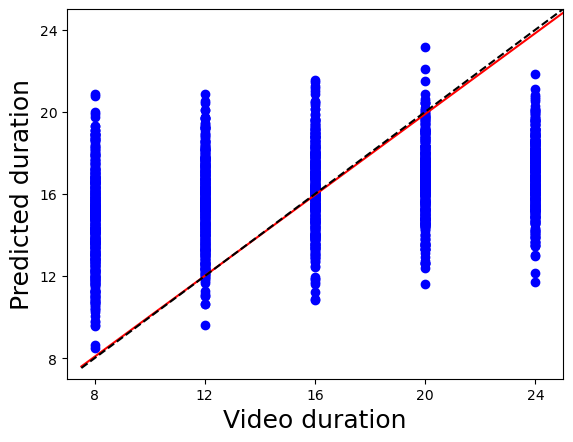

In [15]:
#################################################################################
###################### TREINAMENTO COM LEAVE-ONE-SUBJECT-OUT ############################
#################################################################################

from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#create dataset
class MyDataset(Dataset):
    def __init__(self):
        # Initialize data, download, etc.
        self.n_samples = len(fc_data)

        # here the first column is the class label, the rest are the features
        self.x_data = fc_data
        self.y_data = outcome

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples
        
# create dataset
dataset = MyDataset()
print("=========================")

overwrite = False
load_res = True

counts = samples['subj'].value_counts()
# alpha = 0.5 # Fator de regularização total (combinando L1 e L2)
# l1_list = np.arange(0.1, 1.1, 0.1)  # Proporção de penalização L1 (0 <= l1_ratio <= 1)
l1_list = [1]
n_alphas = 10

region = 'rGlasser'
thr = 'nulo'
task = 'realDur'
data_type = 'smoothed'

for l1_ratio in l1_list:
    
    folder_path = op.join(outdir, 'Elastic-net', region, 'outcome={}_region={}_l1-ratio={}_n-alphas={}_thr={}'.format(
    task, region, l1_ratio, n_alphas, thr))
    if data_type=='smoothed' or data_type=='dubois_pipeline':
        folder_path = op.join(outdir, 'Elastic-net', region, data_type, 'outcome={}_region={}_l1-ratio={}_n-alphas={}_thr={}_RANDOM'.format(
        task, region, l1_ratio, n_alphas, thr))
    print(folder_path)
    outFile = op.join(folder_path, 'results.mat')
    
    if not op.isfile(outFile) or overwrite:
        perf = []
        r2_list = []
        preds = []
        outs = []
        for fold, subj in enumerate(subj_list):
            if str(subj) not in np.ravel(samples['subj']):
                continue
            print(f'Training fold {fold}, includes all subjects but {subj}')
            train_ids = np.ravel(samples.loc[~(samples['subj'] == str(subj)), 'sample'])
            test_ids = np.ravel(samples.loc[(samples['subj'] == str(subj)), 'sample'])
            print(test_ids)
            if len(test_ids)<5:
                print('Test sample is too small, skipping')
                continue
            # Sample elements sequentially from a given list of ids, no replacement.
            train_subsampler = iter(train_ids)
            test_subsampler = iter(test_ids)
            # Define data loaders for training and testing data in this fold
            train_loader = torch.utils.data.DataLoader(
                          dataset, 
                          batch_size=len(train_ids), sampler=train_subsampler)
            test_loader = torch.utils.data.DataLoader(
                          dataset,
                          batch_size=len(test_ids), sampler=test_subsampler)

            # Crie e ajuste o modelo Elastic-Net
            for i, (X_train, y_train) in enumerate(train_loader):
                print(len(X_train))
                elastic_net = ElasticNetCV(l1_ratio=l1_ratio, n_alphas=n_alphas, random_state=42)
                elastic_net.fit(X_train, y_train)

            for i, (X_test, y_test) in enumerate(test_loader):
                # Faça previsões no conjunto de teste
                y_pred = elastic_net.predict(X_test)
                preds.append(list(y_pred))
                outs.append(list(y_test))

                # Avalie o desempenho do modelo
                mse = mean_squared_error(y_test, y_pred)
                rho, p   = stats.pearsonr(np.ravel(y_pred), np.ravel(y_test))
                y_test = y_test.detach().numpy() 
                R2 = 1 - np.sum(np.square(np.log(y_test)-np.log(y_pred))) / np.sum(np.square(np.log(y_test)-np.mean(np.log(y_test))))
                perf.append(rho)
                r2_list.append(R2)
                print(f'Mean Squared Error: {mse}')
                print(f'rho = {rho}, p = {p}, R2 = {R2}')

                # Visualize as previsões e o modelo ajustado
                fig = plt.figure()
                ax = fig.add_axes([0,0,1,1])
                ax.scatter(y_pred, y_test, color='blue', label='Observações reais')
                ax.set_yticks(np.arange(np.min(y_test)-1, np.max(y_test)+1, 5))
                ax.set_xticks(np.arange(np.min(y_pred)-1, np.max(y_pred)+2, 1))
                ax.set_ylabel('Observações')
                ax.set_xlabel('Predições')
                # plt.plot(y_test, y_pred, color='blue', linewidth=3, label='Elastic-Net')
                plt.legend()
                plt.show()

        # saving results
        results = {'rho':np.mean(perf),
                  'fold_perfs':perf,
                  'R2':r2_list,
                  'predicted': preds,
                  'ground_truth':outs
                  }
        if not op.isdir(folder_path):
            os.makedirs(folder_path)
        sio.savemat(outFile, results)

colors = []
if load_res:
    results = sio.loadmat(outFile)
    perf = results['fold_perfs'][0]
    r2_list = results['R2']
    preds = np.squeeze(np.concatenate(results['predicted'][0], axis=1))
    outs = np.squeeze(np.concatenate(results['ground_truth'][0], axis=1))
for R2 in r2_list[0]:
    if R2<0:
        colors.append('r')
    else:
        colors.append('b')
        
print(f'Mean rho is: {np.mean(perf)} +/- {np.std(perf)}')
print(f'Mean R2 is: {np.mean(r2_list)} +/- {np.std(r2_list)}')

# global results
rho,p = stats.pearsonr(np.ravel(preds), np.ravel(outs))
R2 = r2_score(np.ravel(outs), np.ravel(preds))
modelo = sm.OLS(outs, sm.add_constant(preds)).fit()
print(f'Global corr = {rho:.3f}, p = {p:.3f} and global R2 is {R2:.3f}')
print('------> Linear Regression between observed and model {}: beta = {:.2f} ± {:.2f}, p = {:.3f}'
                                  .format(task, modelo.params[1], modelo.bse[1], modelo.f_pvalue))

samples['predicted'] = preds
samples = samples.rename(columns={'dur':'duration'})

# # plotar resumo dos resultados
# X = np.arange(len(perf))
# #         colors = ['r']*(len(perf))
# fig = plt.figure()
# ax = fig.add_axes([0,0,1.4,1])
# bar = ax.bar(X, perf, color=colors, width = 0.9, capsize=5)
# # ax.errorbar(X, perf, error, fmt='o', ecolor = 'black', color='green')
# #         ax.bar_label(bar, fmt='%.3f', fontsize = 10)
# ax.set_xticks(X)
# # ax.set_xticklabels(np.arange(0, len(labels), 1), rotation = (45), fontsize = 8)
# #         ax.set_yticks(np.arange(0, 1.1, 0.1))
# ax.set_yticks(np.arange(0, 0.8, 0.1))
# plt.yticks(fontsize=12)
# ax.set_ylabel('Pearson-r', fontsize=18)
# ax.set_xlabel('Testing folds', fontsize=18)
# # ax.legend(labels=['Inter-network', 'Intra-network'])
# # plt.title('video duration', fontsize=25)
# plt.show()

# PLOTAR PRED X OUTCOME
b, a = modelo.params
ident = np.arange(min(preds)-1, max(preds)+1)
linReg = b + a * ident

fig = plt.figure()
# ax = fig.add_axes([0,0,1.4,1])
plt.scatter(outs, preds, color='blue')
plt.plot(ident, linReg, color='red')
plt.plot(ident, ident, color='black', linestyle='--')
# ax.set_xticks(X)
# ax.set_xticklabels(np.arange(0, len(labels), 1), rotation = (45), fontsize = 8)
#         ax.set_yticks(np.arange(0, 1.1, 0.1))
# ax.set_yticks(np.arange(0, 0.8, 0.1))
# plt.yticks(fontsize=12)
plt.ylabel('Predicted duration', fontsize=18)
plt.xlabel('Video duration', fontsize=18)
plt.ylim([7, 25])
plt.xlim([7, 25])
plt.xticks(np.arange(8, 25, 4))
plt.yticks(np.arange(8, 25, 4))
# ax.legend(labels=['Inter-network', 'Intra-network'])
plt.show()

(array([1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        5.000e+00, 2.400e+01, 6.590e+02, 1.516e+03]),
 array([-14.62468997, -13.03256322, -11.44043647,  -9.84830973,
         -8.25618298,  -6.66405623,  -5.07192948,  -3.47980273,
         -1.88767598,  -0.29554924,   1.29657751]),
 <BarContainer object of 10 artists>)

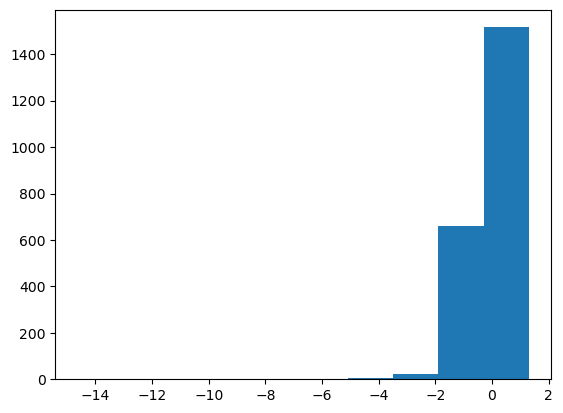

In [8]:
plt.hist(outcome)

In [56]:
# organising data
resdir = 'D:\\ERICK\\MD\\Results\\'
# origdir = 'D:\\ERICK\\MD\\predictions (ORIGINAL)\\'
regions = ['rGlasser']
excluded = [41, 45]
layers = [1, 2, 3]
df_glasser = []

load_file = op.join(datadir, 'master_dataset.csv')
df = pd.read_csv(load_file)

for subject in range(4, 46):
    if subject in excluded:
        df = df[df['rawSubjID'] != subject]
        continue
for region in regions:
    data = {'subj': [], 'duration': [], 'isCity': [], 'report': [], 'humanBias': []}
    data['subj'] = df['subj']
    data['duration'] = df['veridicalDuration']
    data['isCity'] = df['isCity']
    data['report'] = df['humanReport']
    data['humanBias'] = df['humanBias']
    data['FC'] = fc_data

#     df_glasser = pd.DataFrame(data)

# df_glasser = pd.concat(df_glasser, ignore_index=True)

In [62]:
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

target = 'duration'

save_file = op.join(outdir, 'predicted_{}.csv'.format(region))

if target == 'videoType':
    regressor = LogisticRegression(max_iter=1000)
    out = np.array(data.isCity)
else:
    out=np.array(data[target])
    # define model
#     regressor = SVR(kernel='rbf', C=1e3, gamma=0.0001)
    regressor = ElasticNetCV(l1_ratio=1, n_alphas=10, random_state=42)
    
regressor.fit(fc_data, out)
predicted = regressor.predict(fc_data)
rho, p = stats.pearsonr(predicted, out)

# output    = np.array(pd.concat([data.subj,data.duration,data.isCity,data.report, data.humanBias, data.estimationError,
#                                 pd.Series(predicted), data.l1,data.l2,data.l3],axis=1))
# output = pd.DataFrame(output, columns=['subj', 'duration', 'isCity', 'report', 'humanBias', 'estimationError', 
#                                        'predicted','l1', 'l2', 'l3'])
#     output.to_csv(save_file, sep=',', encoding='utf-8')

# # 10-fold cross val
# j = 0
# kf = KFold(n_splits=10, shuffle=True)
# rmse, rho, p, R2 = np.zeros(10), np.zeros(10), np.zeros(10), np.zeros(10)
# accuracy = np.zeros(10)

# for train_index, test_index in kf.split(fc_data):
#     X_train, X_test = fc_data[train_index], fc_data[test_index]
#     Y_train, Y_test = out[train_index], out[test_index]

#     if target == 'videoType':
#         regressor.fit(X_train, Y_train)
#         preds = regressor.predict_proba(X_test)[:, 1]
#         accuracy[j] = accuracy_score(Y_test, preds > 0.5)
#         j += 1
#     else:    
#         regressor.fit(X_train, Y_train)
#         preds = regressor.predict(X_test)

#         rho[j], p[j] = stats.pearsonr(np.ravel(preds), np.ravel(Y_test))
#         R2[j] = 1 - np.sum(np.square(Y_test-preds)) / np.sum(np.square(Y_test-np.mean(Y_test)))
#         rmse[j] = sqrt(mean_squared_error(Y_test, preds))
#         j += 1
# if target == 'videoType':
#     print("Acurácia:", np.mean(accuracy))
# else:
#     print(f'r = {np.mean(rho[rho != 0]):.3f}, p = {np.mean(p[p != 0]):.3f}')
#     print(f'R2 = {np.mean(R2[R2 != 0]):.3f}')
#     print(f'RMSE is: {np.mean(rmse[rmse != 0]):.3f}')

In [11]:
#calculate model bias for each subject
files = ['rGlasser']
durations = [8, 12, 16, 20, 24]
dur_dic = {8:0, 12:1, 16:2, 20:3, 24:4}
modelBias_off = {'rGlasser':[]}
modelBias_city = {'rGlasser':[]}
avgmb_diff = {'rGlasser':[]}
modelBias_all = {'rGlasser':[]}
avgmb_all = {'rGlasser':[]}
avgmb_c = {'rGlasser':[]}
avgmb_o = {'rGlasser':[]}
# outdir = 'D:\\ERICK\\MD\\predictions (ORIGINAL)\\'

for region in files:
    print(region)
    save_file = op.join(outdir, 'predicted_FC_{}.csv'.format(region))
    data = samples
    for subj in range(4, 45): # mudar caso mude o tamanho da amostra
        subset_c = data.loc[(data['subj'] == str(subj)) & (data['isCity'] == 1)]
        subset_o = data.loc[(data['subj'] == str(subj)) & (data['isCity'] == 0)]
        subset = data.loc[(data['subj'] == str(subj))]
        mb_subcity = []
        mb_suboff = []
        mb_suball = []
    
        if len(subset_c) != 0:
            print(f'Sujeito {subj} existe')
    
            for dur in durations:
                mean_dur = subset.groupby('duration')['predicted'].mean().tolist() 
            for ind, row in subset.iterrows():
                modelrep = row['predicted']
                md_idx = dur_dic[row['duration']]
                model_bias = 100*(modelrep-mean_dur[md_idx])/mean_dur[md_idx]
                mb_suball.append(model_bias)
                modelBias_all[region].append(model_bias)
            for ind, row in subset_c.iterrows():
                modelrep = row['predicted']
    #             print('predicted is', modelrep)
                md_idx = dur_dic[row['duration']]
    #             print('mean dur is', mean_dur_c[md_idx])
                model_bias = 100*(modelrep-mean_dur[md_idx])/mean_dur[md_idx]
    #             print('model bias is', model_bias)
                mb_subcity.append(model_bias)
                modelBias_city[region].append(model_bias)
            for ind, row in subset_o.iterrows():
                modelrep = row['predicted']
                md_idx = dur_dic[row['duration']]
                model_bias = 100*(modelrep-mean_dur[md_idx])/mean_dur[md_idx]
                mb_suboff.append(model_bias)
                modelBias_off[region].append(model_bias)
            #calculate diff
            diff = np.mean(mb_subcity)-np.mean(mb_suboff)
    #         print(diff)
            avgmb_diff[region].append(diff)
            #average within subject
            avgmb_c[region].append(np.mean(mb_subcity))
            avgmb_o[region].append(np.mean(mb_suboff))
            avgmb_all[region].append(np.mean(mb_suball))
        
    #overwrite file
    data['modelBias'] = modelBias_all[region]
    data.to_csv(save_file, sep=',', encoding='utf-8')

rGlasser
Sujeito 4 existe
Sujeito 5 existe
Sujeito 6 existe
Sujeito 7 existe
Sujeito 10 existe
Sujeito 11 existe
Sujeito 12 existe
Sujeito 13 existe
Sujeito 14 existe
Sujeito 15 existe
Sujeito 16 existe
Sujeito 17 existe
Sujeito 18 existe
Sujeito 19 existe
Sujeito 20 existe
Sujeito 21 existe
Sujeito 22 existe
Sujeito 23 existe
Sujeito 24 existe
Sujeito 25 existe
Sujeito 26 existe
Sujeito 27 existe
Sujeito 28 existe
Sujeito 29 existe
Sujeito 30 existe
Sujeito 31 existe
Sujeito 32 existe
Sujeito 33 existe
Sujeito 34 existe
Sujeito 35 existe
Sujeito 36 existe
Sujeito 37 existe
Sujeito 38 existe
Sujeito 39 existe
Sujeito 40 existe
Sujeito 42 existe
Sujeito 43 existe
Sujeito 44 existe


In [12]:
import warnings
warnings.filterwarnings("ignore")

# outdir = 'D:\\ERICK\\MD\\predictions (ORIGINAL)\\'
files = ['rGlasser']
columns = ['Região', 'Viés de duração', '95% IC', 'chi-quadrado', 'valor-p']
df = pd.DataFrame(columns=columns)
n=38

for region in files: 
    print('--------------------------------')
    print(region)
    model_file = op.join(outdir, 'predicted_FC_{}.csv'.format(region))
    model_data = pd.read_csv(model_file)
#     #plot model bias hist
#     plt.hist(model_data['modelBias'])
#     plt.show()
    
    #Regressão => bias (human) = B0 + B1 * bias (model)
    x = model_data['modelBias']
    y = model_data['humanBias']
    #corr
    rho,p = stats.pearsonr(x, y)
    R2 = 1 - np.sum(np.square(y-x)) / np.sum(np.square(y-np.mean(y)))
    print('Correlation between human and model bias: r = {:.2f}, p = {:.3f}'
          .format(rho, p))
    print('R2 = {:.2f}'.format(R2))
    modelo = sm.OLS(y, sm.add_constant(x)).fit()
    print('Linear Regression between human and model bias: beta = {:.2f} ± {:.2f}, p = {:.3f}'
          .format(modelo.params[1], modelo.bse[1], modelo.f_pvalue))
    
    #EFEITO FIXO = MODEL BIAS
    vc = {'subj': '1 + C(subj)'}
    # Ajustar o modelo reduzido sem o efeito fixo
    model_reduced = sm.MixedLM.from_formula("humanBias ~ 1", vc_formula=vc, data=model_data, groups=model_data['subj'])
    result_reduced = model_reduced.fit()
    # Ajustar o modelo completo com o efeito fixo
    model_full = sm.MixedLM.from_formula("humanBias ~ 1 + modelBias", vc_formula=vc, data=model_data, groups=model_data['subj'])
    result_full = model_full.fit()
    # Calcular a diferença nas log-verossimilhanças
    llf_full = result_full.llf
    llf_reduced = result_reduced.llf
    lrt = -2 * (llf_reduced - llf_full)
    # Calcular o valor p do teste
    p_value = chi2.sf(lrt, 1)
    print('Using model bias as fixed effect: chi-sqr = {:.2f}, p = {:.3f}'
          .format(lrt, p_value))
    
    #EFEITO FIXO = CENA
    vc = {'subj': '1 + C(subj)'}
    # Ajustar o modelo reduzido sem o efeito fixo
    model_reduced = sm.MixedLM.from_formula("modelBias ~ 1", vc_formula=vc, data=model_data, groups=model_data['subj'])
    result_reduced = model_reduced.fit()
    # Ajustar o modelo completo com o efeito fixo
    model_full = sm.MixedLM.from_formula("modelBias ~ 1 + isCity", vc_formula=vc, data=model_data, groups=model_data['subj'])
    result_full = model_full.fit()
    # Calcular a diferença nas log-verossimilhanças
    llf_full = result_full.llf
    llf_reduced = result_reduced.llf
    lrt = np.round(-2 * (llf_reduced - llf_full), 2)
    # Calcular o valor p do teste
    p_value = np.round(chi2.sf(lrt, 1), 3)
    #calculate and print statistics
    mean = np.round(np.mean(avgmb_diff[region]), 2)
    SE = np.round(np.std(avgmb_diff[region], ddof=1)/np.sqrt(n), 2)
    z = 1.96  # Valor crítico para um intervalo de confiança de 95%
    lower_bound = np.round(mean - (z * SE), 2)
    upper_bound = np.round(mean + (z * SE), 2)
    print('Using scene as fixed effect: M±SEdiff = {:.2f} ± {:.2f} (normalized bias, %), 95% CI [{:.2f}, {:.2f}], chi-sqr = {:.2f}, p = {:.3f}'
          .format(mean, SE, lower_bound, upper_bound, lrt, p_value))
    
    linha = [region, '{} ± {}'.format(mean, SE), [lower_bound, upper_bound], lrt, p_value]
    df.loc[len(df)] = linha
    
# outFile = op.join(outdir, 'lmm_table_rep.csv')
# df.to_csv(outFile, sep=',', encoding='utf-8')

--------------------------------
rGlasser
Correlation between human and model bias: r = -0.01, p = 0.556
R2 = -0.11
Linear Regression between human and model bias: beta = -0.04 ± 0.07, p = 0.556
Using model bias as fixed effect: chi-sqr = -3.20, p = 1.000
Using scene as fixed effect: M±SEdiff = 0.44 ± 0.54 (normalized bias, %), 95% CI [-0.62, 1.50], chi-sqr = 0.98, p = 0.322


In [23]:
# for i in range(len(fc_data)):
#     print(i)
#     plt.hist(fc_data[i])

# # plt.hist(fc_data[120])

D:\ERICK\MD\prediction_data\Logistic Regression\rGlasser\outcome=videoType_region=rGlasser_l1-ratio=0.5_TESTE
Training fold 0, includes all subjects but 4
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
2100
acc = 0.6 and auc = 0.6533333333333333
Training fold 1, includes all subjects but 5
[60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]
2120
acc = 0.6 and auc = 0.6875
Training fold 2, includes all subjects but 6
[100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159]
2100
acc = 0.6833333333333333 and auc = 0.75
Training fold 3, includes all subjects but 7
[160 161 162 163 164 165 166 167 168 

2080
acc = 0.65 and auc = 0.698125
Training fold 24, includes all subjects but 31
[1400 1401 1402 1403 1404 1405 1406 1407 1408 1409 1410 1411 1412 1413
 1414 1415 1416 1417 1418 1419 1420 1421 1422 1423 1424 1425 1426 1427
 1428 1429 1430 1431 1432 1433 1434 1435 1436 1437 1438 1439 1440 1441
 1442 1443 1444 1445 1446 1447 1448 1449 1450 1451 1452 1453 1454 1455
 1456 1457 1458 1459]
2100
acc = 0.7333333333333333 and auc = 0.82
Training fold 25, includes all subjects but 32
[1460 1461 1462 1463 1464 1465 1466 1467 1468 1469 1470 1471 1472 1473
 1474 1475 1476 1477 1478 1479 1480 1481 1482 1483 1484 1485 1486 1487
 1488 1489 1490 1491 1492 1493 1494 1495 1496 1497 1498 1499 1500 1501
 1502 1503 1504 1505 1506 1507 1508 1509 1510 1511 1512 1513 1514 1515
 1516 1517 1518 1519]
2100
acc = 0.7 and auc = 0.7777777777777778
Training fold 26, includes all subjects but 33
[1520 1521 1522 1523 1524 1525 1526 1527 1528 1529 1530 1531 1532 1533
 1534 1535 1536 1537 1538 1539 1540 1541 1542 1543 1

<Figure size 640x480 with 0 Axes>

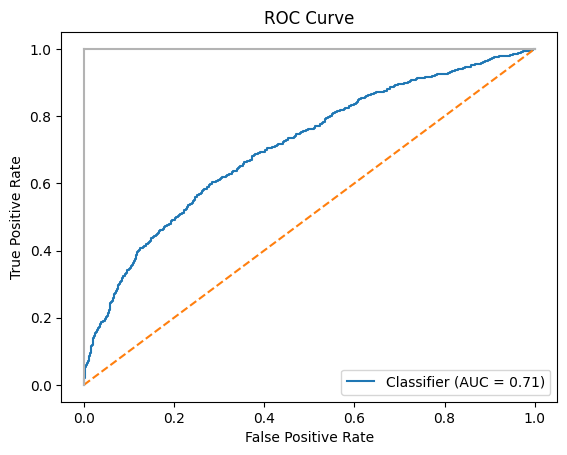

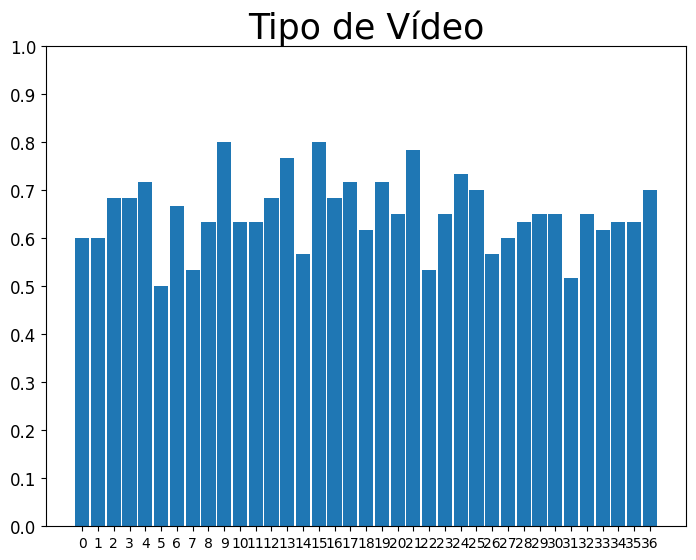

In [27]:
#################################################################################
###################### CLASSIFICAÇÃO TIPO DE VÍDEO ############################
#################################################################################

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay

#create dataset
class MyDataset(Dataset):
    def __init__(self):
        # Initialize data, download, etc.
        self.n_samples = len(fc_data)

        # here the first column is the class label, the rest are the features
        self.x_data = fc_data
        self.y_data = outcome

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples
        
# create dataset
dataset = MyDataset()
print("=========================")
# task = 'videoType'
# region = 'visualNet'

overwrite = True
load_res = True

counts = samples['subj'].value_counts()
l1_ratio=0.5

folder_path = op.join(outdir, 'Logistic Regression', region, 'outcome={}_region={}_l1-ratio={}_TESTE'.format(
    task, region, l1_ratio))
print(folder_path)
if not op.isdir(folder_path):
    os.makedirs(folder_path)
outFile = op.join(folder_path, 'results.mat')

if not op.isfile(outFile) or overwrite:
    perf = []
    auc_list = []
    preds = []
    outs = []
    for fold, subj in enumerate(subj_list):
        if str(subj) not in np.ravel(samples['subj']):
            continue
        print(f'Training fold {fold}, includes all subjects but {subj}')
        train_ids = np.ravel(samples.loc[~(samples['subj'] == str(subj)), 'sample'])
        test_ids = np.ravel(samples.loc[(samples['subj'] == str(subj)), 'sample'])
        print(test_ids)
        # Sample elements sequentially from a given list of ids, no replacement.
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
        # Define data loaders for training and testing data in this fold
        train_loader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=len(train_ids), sampler=train_subsampler)
        test_loader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=len(test_ids), sampler=test_subsampler)

        # Crie e ajuste o modelo
        for i, (X_train, y_train) in enumerate(train_loader):
            print(len(X_train))
            model = LogisticRegression(solver='saga', penalty="elasticnet", l1_ratio=l1_ratio, max_iter=50)
            model.fit(X_train, y_train)

        for i, (X_test, y_test) in enumerate(test_loader):
            # Faça previsões no conjunto de teste
            y_pred = model.predict_proba(X_test)[:, 1]
            preds.append(y_pred)
            outs.append(y_test)

            # Avalie o desempenho do modelo
            y_test = y_test.detach().numpy() 
            acc = accuracy_score(y_test, y_pred > 0.5)
            perf.append(acc)
            auc = roc_auc_score(y_test, y_pred)
            auc_list.append(auc)
            print(f'acc = {acc} and auc = {auc}')

#             # Visualize as previsões e o modelo ajustado
#             fig = plt.figure()
#             ax = fig.add_axes([0,0,1,1])
#             ax.scatter(y_pred, y_test, color='blue', label='Observações reais')
#             ax.set_yticks(np.arange(-3, 4, 1))
#             ax.set_xticks(np.arange(-3, 4, 1))
#             ax.set_ylabel('Observações')
#             ax.set_xlabel('Predições')
#             # plt.plot(y_test, y_pred, color='blue', linewidth=3, label='Elastic-Net')
#             plt.legend()
#             plt.show()
            
    # saving results
    results = {'acc':perf,
               'auc':auc_list,
              'fold_perfs':perf,
              'predicted': preds,
              'ground_truth':outs}
    sio.savemat(outFile, results)

if load_res:
    results = sio.loadmat(outFile)
    perf = results['fold_perfs'][0]
    preds = np.squeeze(np.concatenate(results['predicted'][0], axis=1))
    outs = np.squeeze(results['ground_truth'])
    auc_list = results['auc']
        
print(f'Mean acc is: {np.mean(perf)} +/- {np.std(perf)} and mean auc is: {np.mean(auc_list)} +/- {np.std(auc_list)}')

#ROC curve
plt.figure()
outcome = np.squeeze(np.concatenate(outs, axis=1))
auc = roc_auc_score(outcome, preds)
print(f'Final AUC score: {auc}')

RocCurveDisplay.from_predictions(outcome, preds)

plt.title(f'ROC Curve')
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
# plt.savefig(op.join(thisOutDir, 'Figures', "ROC_{}.jpeg".format(session)), format='jpeg')

# plotar resumo dos resultados
X = np.arange(len(perf))
#         colors = ['r']*(len(perf))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
bar = ax.bar(X, perf, width = 0.9, capsize=5)
# ax.errorbar(X, perf, error, fmt='o', ecolor = 'black', color='green')
#         ax.bar_label(bar, fmt='%.3f', fontsize = 10)
ax.set_xticks(X)
# ax.set_xticklabels(np.arange(0, len(labels), 1), rotation = (45), fontsize = 8)
#         ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.1, 0.1))
plt.yticks(fontsize=12) 
# ax.set_ylabel(ylabel, fontsize=18)
# ax.legend(labels=['Inter-network', 'Intra-network'])
plt.title('Tipo de Vídeo', fontsize=25)
plt.show()

In [30]:
model.coef_.shape

(1, 64620)

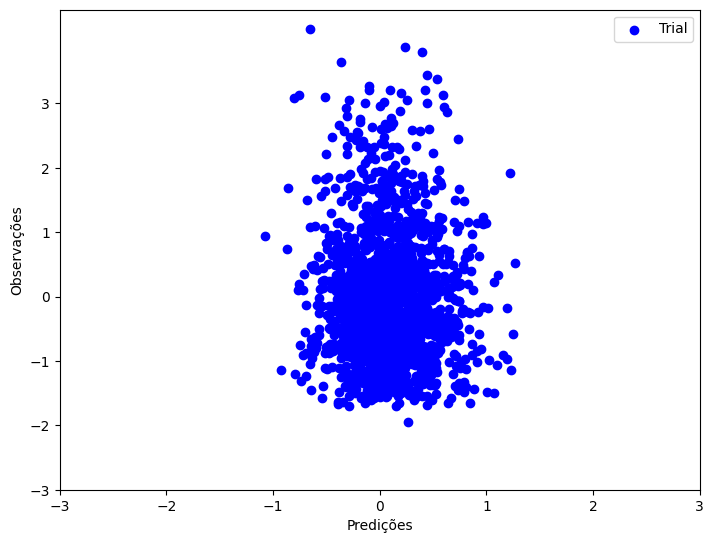

In [40]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(preds, outcome, color='blue', label='Trial')
ax.set_yticks(np.arange(-3, 4, 1))
ax.set_xticks(np.arange(-3, 4, 1))
ax.set_ylabel('Observações')
ax.set_xlabel('Predições')
# plt.plot(y_test, y_pred, color='blue', linewidth=3, label='Elastic-Net')
plt.legend()
plt.show()

In [23]:
# #################################################################################
# ###################### TREINAMENTO COM STRATIFIED CV ############################
# #################################################################################

# from sklearn.linear_model import ElasticNet
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error

# targ = samples.loc[:, 'subj']
# skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=1029)
# cv = skf.split(samples, targ)
# perf = []
# r2_list = []
# labels = []
# alpha = 0.9 # Fator de regularização total (combinando L1 e L2)
# l1_ratio = 0  # Proporção de penalização L1 (0 <= l1_ratio <= 1)

# folder_path = op.join(outdir, 'Elastic-net','outcome={}_region={}'.format(task, region))
# if not op.isdir(folder_path):
#     os.mkdir(folder_path)
# outFile = op.join(folder_path, 'results.mat')

# for fold, (train_ids, test_ids) in enumerate(cv):
#     print(f'Training fold {fold}')
#     # Sample elements sequentially from a given list of ids, no replacement.
#     train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
#     test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
#     # Define data loaders for training and testing data in this fold
#     train_loader = torch.utils.data.DataLoader(
#                   dataset, 
#                   batch_size=len(train_ids), sampler=train_subsampler)
#     test_loader = torch.utils.data.DataLoader(
#                   dataset,
#                   batch_size=len(test_ids), sampler=test_subsampler)

#     # Crie e ajuste o modelo Elastic-Net
# #     labels.append(str(i)+str(j))
# #     print(f'Alpha is {a} and l1 is: {l1}')
#     for i, (X_train, y_train) in enumerate(train_loader):
#         print(len(X_train))
#         elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
#         elastic_net.fit(X_train, y_train)
    
#     for i, (X_test, y_test) in enumerate(test_loader):
#         # Faça previsões no conjunto de teste
#         y_pred = elastic_net.predict(X_test)

#         # Avalie o desempenho do modelo
#         mse = mean_squared_error(y_test, y_pred)
#         rho, p   = stats.pearsonr(np.ravel(y_pred), np.ravel(y_test))
#         y_test = y_test.detach().numpy() 
#         R2 = r2_score(np.ravel(y_test), np.ravel(y_pred))
#         perf.append(rho)
#         r2_list.append(R2)
#         print(f'Mean Squared Error: {mse}')
#         print(f'rho = {rho}, p = {p}')

#         # Visualize as previsões e o modelo ajustado
#         plt.scatter(y_test, y_pred, color='blue', label='Observações reais')
#         # plt.plot(y_test, y_pred, color='blue', linewidth=3, label='Elastic-Net')
#         plt.legend()
#         plt.show()
# print(f'Mean rho is: {np.mean(perf)} +/- {np.std(perf)} ')
# print(f'Mean R2 is: {np.mean(r2_list)} +/- {np.std(r2_list)} ')

# # saving results
# results = {'rho' = np.mean(perf)
#           'fold_perfs' = perf
#           'R2' = r2_list}
# sio.savemat(outFile, results)

In [14]:
r2_list

[-1.2727583915166494,
 -0.663873983386732,
 -0.6088741460556482,
 -0.12281037360216729,
 -1.9363114860250827,
 -14.68219866919192,
 0.10921829804436778,
 -0.36628847110225604,
 -0.5992394458508106,
 -0.3704638993677276,
 -0.4544841805479951,
 -0.2830929819028516,
 0.12877772616393846,
 -1.8185612053081264,
 -0.7425596514432411,
 -1.271543674539899,
 -0.0469615624248223,
 -0.4707184471503705,
 -0.4720378146722639,
 -1.5510714737810272,
 -0.10604194871730832,
 -0.28970988565559264,
 -6.867232780119188,
 -0.2676507822481,
 -0.7871685503527797,
 -0.41617092506227626,
 -0.6388937596233752,
 -0.2742558868995517,
 -0.3301065698783183,
 -0.36625688167595705,
 -1.168485690437917,
 -0.6409644130109196,
 -0.30022919974440154,
 -0.08451127905284306,
 -0.26509084463073695,
 -0.03857628468662044]

In [360]:
#VIDEO DURATION
def runPrediction(ts_data, target, outcome, model, outDir, k_folds, num_epochs, batch_size, 
                  dropout, learning_rate, step_size, gamma, num_classes, criterion, reload_model, overwrite, confounds):
    
    if not op.isdir(outDir):
        os.mkdir(outDir)
    
    # Create plot directory
    plotDir = op.join(outDir, 'Figures')
    if not op.isdir(plotDir):
        os.mkdir(plotDir)
        
    n_samples       = ts_data.shape[0] 
    seq_len      = ts_data.shape[1]
    timepoints      = ts_data.shape[2]
    
    ground_truth = np.array(np.ravel(outcome))
#     if target == '':
#         score = np.array(np.ravel(df[SM].replace(2, 0)))
#         print(score)
#         stratified = False
#     else:
#         standardize = lambda x: (x-x.mean()) / x.std() #* 15. + 100.
#         score        = np.array(np.ravel(df[SM].pipe(standardize)))
#         stratified = True
    
    class MyDataset(Dataset):
        def __init__(self):
            # Initialize data, download, etc.
            self.n_samples = n_samples 

            # here the first column is the class label, the rest are the features
            self.x_data = ts_data
            self.y_data = ground_truth

        # support indexing such that dataset[i] can be used to get i-th sample
        def __getitem__(self, index):
            return self.x_data[index], self.y_data[index]

        # we can call len(dataset) to return the size
        def __len__(self):
            return self.n_samples
        
    # create dataset
    dataset = MyDataset()
    print("=========================")

    if model=='BiLSTMWithAttention':
    # Define the K-fold Cross Validator
        kfold = KFold(n_splits=k_folds, shuffle=True)
        cv = kfold.split(dataset)

        # K-fold Cross Validation model evaluation
        for fold, (train_val_ids, test_ids) in enumerate(cv):
            val_ids = np.random.choice(train_val_ids, 20, replace=False) 
    #                     print(f'Val_ids: {val_ids}')
            train_ids = list(train_val_ids)
            for i in val_ids:
                train_ids.remove(i)
            print(f'Test_ids: {test_ids}')
            
            outFile = op.join(outDir,'{}.mat'.format(
               'Fold_' + str(fold)))
            print(outFile) 

            if op.isfile(outFile) and not overwrite:
                continue

#             # REMOVE CONFOUNDS
#             conMat = None
#             if len(confounds)>0:
#                 for confound in confounds:
#                     conVec = defConVec(df,confound,session)
#                     # add to conMat
#                     if conMat is None:
#                         conMat = np.array(np.ravel(conVec))
#                     else:
#                         print(confound,conMat.shape,conVec.shape)
#                         conMat = np.vstack((conMat,conVec))
#                 # if only one confound, transform to matrix
#                 if len(confounds)==1:
#                     conMat = conMat[:,np.newaxis]
#                 else:
#                     conMat = conMat.T

#                 corrBef = []
#                 for i in range(len(confounds)):
#                     corrBef.append(stats.pearsonr(conMat[:,i].T,score)[0])
#                 print('maximum corr before decon: ',max(corrBef))

#                 regr        = linear_model.LinearRegression()
#                 regr.fit(conMat[train_ids,:], score[train_ids])
#                 fittedvalues = regr.predict(conMat)
#                 fold_score        = score - np.ravel(fittedvalues)
#                 print("Score min: {}".format(np.min(fold_score)))

#                 corrAft = []
#                 for i in range(len(confounds)):
#                     corrAft.append(stats.pearsonr(conMat[:,i].T,fold_score)[0])
#                 print('maximum corr after decon: ',max(corrAft))

            # replace decon score
#             if decon == 'noDecon':
#                 fold_score = verDur
#             dataset.y_data = fold_score
            if reload_model:
                test_ids = np.squeeze(test_list[fold])
            print(test_ids)

            # Print
            print('FOLD {}'.format(fold))
            print('--------------------------------')
            net = BiLSTMWithAttention(num_layers, hidden_size, num_classes, input_size, dropout).to(device)
            net.apply(reset_weights)
            print('--------------------------------')
            print(net)
            print('--------------------------------') 

            # Sample elements sequentially from a given list of ids, no replacement.
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
            test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

            # Define data loaders for training and testing data in this fold
            train_loader = torch.utils.data.DataLoader(
                          dataset, 
                          batch_size=batch_size, sampler=train_subsampler)
            test_loader = torch.utils.data.DataLoader(
                          dataset,
                          batch_size=200, sampler=test_subsampler)

            # Run the training loop for defined number of epochs
            print(f'Parameters: LR = {learning_rate}, Step size = {step_size}, gamma = {gamma}' )
            optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)    
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
            loss_list = []
            val_list = []

            # Early stopping
            last_loss = 1
            patience = 3
            trigger_times = 0

            for epoch in range(1, num_epochs+1):
                outModel = op.join(outDir, f'model_fold{fold}.pth') 
                print(outModel)
                if op.isfile(outModel) and reload_model:
                    print(f'Reloading model')
                    print(f'Test_ids: {test_ids}') 
                    net.load_state_dict(torch.load(outModel))
                    break

                # Print epoch
                print('Starting epoch {}'.format(epoch))

                # TRAIN
                net.train()
                start_time     = time()

                avg_loss = []
                for i, (ts, outcome) in enumerate(train_loader):  
                    # origin shape: [N, n_regions, timepoints]
                    ts = ts.reshape(-1, timepoints, seq_len).to(device)
                    if target=='videoType':
                        outcome = torch.tensor(outcome, dtype=torch.long).to(device)
                    else: 
                        outcome = torch.tensor(outcome, dtype=torch.float32).to(device)

                    # Zero the gradients
                    optimizer.zero_grad()

                    # Forward pass
                    outputs = net(ts, target).to(device)
                    print(torch.squeeze(outcome))
                    loss = criterion(outputs, outcome)

                    # Backward and optimize
                    #optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    # Print statistics
                    avg_loss.append(loss.item())
                    print('Loss after mini-batch %5d: %.3f' %
                              (i, loss.item()))

                elapsed_time = time() - start_time
                scheduler.step()
                avg_loss = statistics.mean(avg_loss)
                loss_list.append(avg_loss)

                #validation
                net.eval()
                with torch.no_grad():
                    ts = ts_data[val_ids]
                    ts = ts.reshape(-1, timepoints, seq_len).to(device)
                    outcome = ground_truth[val_ids]
                    if target=='videoType':
                        outcome = torch.tensor(outcome, dtype=torch.long).to(device)
                    else: 
                        outcome = torch.tensor(outcome, dtype=torch.float32).to(device)

                    correct, total = 0, 0

                    val_out = net(ts, target).to(device)
                    print(outcome)
                    val_loss = criterion(val_out, outcome)
                    print('Val_Loss after epoch %5d: %.3f' %
                          (epoch, val_loss))
                    val_list.append(val_loss.item())
                
#                 # Early stopping
#                 current_loss = val_loss
#                 if current_loss > last_loss:
#                     trigger_times += 1
#                     print('Trigger Times:', trigger_times)

#                     if trigger_times >= patience:
#                         print('Early stopping!\nStart to test process.')
#                         break
#                 else:
#                     print('trigger times: 0')
#                     trigger_times = 0
#                 last_loss = current_loss

                # Print accuracy
                if target=='videoType':
                    _, predicted = torch.max(val_out.data, 1)
                    total += len(outcome)
                    correct += (predicted == outcome).sum().item()
                    print('Accuracy for epoch %d: %d %%' % (epoch, 100.0 * correct / total))
                    print('--------------------------------')
                else: 
                    outcome = np.asarray(torch.Tensor.cpu(outcome))
                    val_out = np.asarray(torch.Tensor.cpu(val_out))
                    rho,p   = stats.pearsonr(np.ravel(val_out), np.ravel(outcome))
                    print('Performance for epoch {} is: r = {}, p = {}'.format(epoch, rho, p))
                    print('--------------------------------')

                print("Trained model in {0:02d}h:{1:02d}min:{2:02d}s".format(int(elapsed_time//3600),
                                                                             int((elapsed_time%3600)//60),int(elapsed_time%60)))   

            # Process is complete.
            print('Training process has finished. Saving trained model.')

            # Print about testing
            print('Starting testing')
    
            # Saving the model and loss
            if not reload_model:
                save_path = op.join(outDir,'model_fold{}.pth'.format(fold))
                torch.save(net.state_dict(), save_path)
            loss_path = op.join(outDir,'loss_fold{}.csv'.format(fold))
            loss_list = np.array(loss_list).reshape(len(loss_list), 1)
            val_loss = np.array(val_list).reshape(len(val_list), 1)
            total_loss = pd.DataFrame(np.concatenate((loss_list, val_loss), axis=1), columns=['Train Loss', 'Val Loss'])
            print(total_loss)
            total_loss.to_csv(loss_path, sep=',', encoding='utf-8')

            #Plot curve
            get_ipython().run_line_magic('matplotlib', 'inline')
            epochs = np.arange(1, len(loss_list)+1, 1)
            plt.title(f'Loss Curve: Fold {fold}')
            plt.plot(epochs, loss_list, label='Train loss')
            plt.plot(epochs, val_loss, label='Val Loss')
            plt.legend()
            plt.xlabel('Epoch')
            plt.ylabel('Cost function')
            plt.show()
            plt.savefig(op.join(plotDir, 'Training_curves_Fold_{}.png'.format(fold)), format='png')


            # PREDICT
            print(test_ids)
            net.eval()
#             deconv = False
            with torch.no_grad():
                for (ts, outcome) in test_loader:
                    ts = ts.reshape(-1, timepoints, seq_len).to(device)
                    if target=='videoType':
                        outcome = torch.tensor(outcome, dtype=torch.long).to(device)
                    else: 
                        outcome = torch.tensor(outcome, dtype=torch.float32).to(device)
                    pred     =  net(ts, target).to(device)

            test_loss = criterion(pred, outcome)
            print(f'Test_Loss is:  {test_loss.item()}')

            # Print accuracy
            correct, total = 0, 0
            if target=='videoType':
                probs = np.asarray(torch.Tensor.cpu(pred))
                outcome = np.asarray(torch.Tensor.cpu(outcome))
                print('Predicted probs:', probs.shape)
                _, pred = torch.max(pred.data, 1)
                pred = np.asarray(torch.Tensor.cpu(pred))
                total += len(outcome)
                correct += (pred == outcome).sum().item()
                print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
                print('--------------------------------')
            else: 
                pred = np.asarray(torch.Tensor.cpu(pred))
                outcome = np.asarray(torch.Tensor.cpu(outcome))
                rho,p   = stats.pearsonr(np.ravel(pred), np.ravel(outcome))
                print('Performance for fold {} is: r = {}, p = {}'.format(fold, rho, p))
                probs = 'não se aplica'
                print('--------------------------------')
            
            results        = {
                        'test_index':test_ids,
                        'score':np.asarray(outcome).flatten(),
                        'pred':np.asarray(pred).flatten(),
                        'probs':probs,
#                         'deconv weights':[net.deconv1.weight.data,
#                                               net.deconv2.weight.data,
#                                               net.deconv3.weight.data],
                        'complete epochs': epoch
                        }
#             print(results)
            sio.savemat(outFile, results)
            
        return dataset

In [ ]:
# #----------------------
# # predict!
# #----------------------
# overwrite = True
# continuing = False #quando não terminou todas as folds
# overwrite_res = False
# reload_model = False
# decon = 'noDecon'
# Task = ['verDur']
# # outDir = '/home/brunovieira/ERICK/Results'

# # Hyper-parameters
# k_folds = 5
# num_epochs = 50
# batch_size = 40
# dropout = 0.5

# learning_rate = [0.1, 0.01, 0.001, 0.0001]
# step_size = [1, 2, 3]
# gamma = [0.01, 0.1, 0.2, 0.5]

# #seed
# seed = 1029
# np.random.seed(seed)
# torch.manual_seed(seed)
                            
# # print ('nsub{}, {}, {}'.format(ts_data.shape[0], session, fctype))
# for model in ['BiLSTMWithAttention']:
#     print ('> {}'.format(model))
#     for target in Task:
#         # Loss and optimizer
#         if target == 'verDur':
#             num_classes = 1
#             criterion = nn.MSELoss()
#         if target == 'videoType':
#             num_classes = 2
#             criterion = nn.CrossEntropyLoss()
#         print ('--------> '+ target)
#         for lr in learning_rate:
#             for ss in step_size:
#                 for g in gamma:     
#                     thisOutDir = op.join(outdir, 'BiLSTM', target, '{}_{}_lr={}_ss={}_g={}_seed={}_shuffle_{}'.format(target, model, lr, ss, g, seed, decon))
#                     if decon == 'noDecon':
#                         confounds=[]

#                     #run prediction
#                     if overwrite or not op.isdir(thisOutDir) or continuing:
#                         print(thisOutDir)
#                         runPrediction(ts_data, target=target, outcome=outcome, model=model, outDir=thisOutDir, k_folds=k_folds, num_epochs=num_epochs, 
#                                       batch_size=batch_size, dropout=dropout, learning_rate=lr, step_size=ss, gamma=g, 
#                                       num_classes=num_classes, criterion=criterion, reload_model=reload_model, overwrite=overwrite, confounds=confounds)

#                    # merge cross-validation folds, save results
#                     print(thisOutDir)
#                     resFile     = op.join(thisOutDir,'result.mat') 

#                     if (not op.isfile(resFile)) or overwrite_res:
#                         predictions_pos = np.zeros([ts_data.shape[0], 1])
#                         probs_pos    = np.zeros([ts_data.shape[0], 1])
#                         obs                = np.zeros([ts_data.shape[0], 1])
#                         corr_list = []
#                         r2_list = []
#                         false_list = []
#                         for fold in range(k_folds):
#                             cvResFile = op.join(thisOutDir, '{}.mat'.format(
#                                 'Fold_' + str(fold)))
#                             results = sio.loadmat(cvResFile)
#                             print(results['test_index']) 
#                             print('-------------------------------')
#                             print('Final results for fold', fold)
#                             if target=='videoType': 
#                                 score = np.squeeze(results['score'])
#                                 probs = np.squeeze(results['probs'][:, 1])
#                                 pred = np.squeeze(results['pred'])
#                                 false_positive_rate, true_positive_rate, threshold = roc_curve(score, probs)
#                                 auc = roc_auc_score(np.squeeze(results['score']), np.squeeze(results['probs'][:, 1]))
#                                 print(f'AUC score for fold {fold}: {auc}')
#                                 total = len(score)
#                                 correct = (pred == score).sum().item()
#                                 print('Accuracy:' , (100.0 * correct / total))

#                                 true = pred == score
#                                 false = np.count_nonzero(pred != score)
#                                 print(false)
#                                 false_list.append(false)
#                                 combined_array = np.column_stack((true, np.squeeze(results['test_index'])))
#             #                         %matplotlib inline
#             #                         plt.bar(np.squeeze(results['test_index']), true)
#             #                         plt.show()
#             #                         for row in combined_array:
#             #                             print(row[0], row[1])
#                             else:
#                                 rho, p   = stats.pearsonr(np.ravel(results['pred']), np.ravel(results['score']))
#                                 pred, score = np.ravel(results['pred']), np.ravel(results['score'])
#                                 R2 = 1 - np.sum(np.square(score-pred)) / np.sum(np.square(score-np.mean(score)))
#                                 print(f'Peformance for fold {fold}: r = {rho}, p = {p}')
#                                 corr_list.append(rho)
#                                 r2_list.append(R2)
#                             for test_index in results['test_index']:
#                                 if target=='videoType':
#                                     probs_pos[test_index]          = results['probs'][:, 1].reshape(len(results['probs']), 1)
#                                 predictions_pos[test_index]    = results['pred'].T
#                                 obs[test_index]                = results['score'].T

# #                             dataFile = op.join(thisOutDir,'loss_fold{}.csv'.format(fold))
# #                             if op.isfile(dataFile):
# #                                 loss = pd.read_csv(dataFile) 
# #                                 %matplotlib inline
# #                                 epochs = np.arange(1, len(loss)+1, 1)
# #                                 plt.title(f'Loss Curve: Fold {fold}')
# #                                 plt.plot(epochs, loss['Train Loss'], label='Train Loss')
# #                                 plt.plot(epochs, loss['Val Loss'], label='Validation Loss')
# #                                 plt.legend()
# #                                 plt.xlabel('Epoch')
# #                                 plt.ylabel('EQM')
# #                                 plt.show()

#                         if target=='videoType':
#                             total = len(obs)
#                             correct = (predictions_pos == obs).sum().item()
#                             acc = (100.0 * correct / total)
#                             print('Final accuracy:' , acc)

#                             #ROC curve
#                             plt.figure()
#                             false_positive_rate, true_positive_rate, threshold = roc_curve(obs, probs_pos)
#                             auc = roc_auc_score(obs, probs_pos)
#                             print(f'Final AUC score: {auc}')

#             #                 RocCurveDisplay.from_predictions(obs, probs_pos)

#             #                 plt.title(f'ROC Curve - {session}')
#             #                 plt.plot([0, 1], ls="--")
#             #                 plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
#             #                 plt.ylabel('True Positive Rate')
#             #                 plt.xlabel('False Positive Rate')
#             #                 plt.show()
#             #                 plt.savefig(op.join(thisOutDir, 'Figures', "ROC_{}.jpeg".format(session)), format='jpeg')

#                             results = {'obs':obs,
#                                        'pred':predictions_pos, 'auc':auc, 'acc':acc}

#                         else:
#                             rho,p   = stats.pearsonr(np.ravel(predictions_pos),np.ravel(obs)) 
#                             results = {'obs':obs,
#                                        'pred':predictions_pos, 
#                                        'rho':rho, 'p': p,
#                                        'fold-avg-rho':np.mean(corr_list), 'fold-std':np.std(corr_list),
#                                        'fold-avg-R2':np.mean(r2_list), 'R2-std':np.std(r2_list)}
#                             print(f'Mean rho is: {np.mean(corr_list)} +/- {np.std(corr_list)}')
#                             print(f'Mean R2 is: {np.mean(r2_list)} +/- {np.std(r2_list)}')

#             #                 # PLOT OBSERVED vs. PREDICTED (cf. Pineiro et al, Ecological Modeling 2008)
#             #                 g  = sns.jointplot((np.ravel(predictions_pos), np.ravel(obs)))
#             #                 # adjust the axes
#             #                 lims = [-3,3]
#             #                 g.ax_joint.set_xlim(lims)
#             #                 g.ax_joint.set_ylim(lims)
#             #                 g.ax_joint.set_xlabel('predicted')
#             #                 g.ax_joint.set_ylabel('observed')
#             #                 # PLOT THE 1:1 line
#             #                 line = plt.Line2D(lims,lims, c='k', linestyle='--')
#             #                 g.ax_joint.add_line(line)
#             #                 # FIT REGRESSION LINE
#             #                 regr = linear_model.LinearRegression()
#             #                 regr.fit(predictions_pos.reshape(-1,1), obs.reshape(-1,1))
#             #                 line = plt.Line2D(np.array(lims).reshape(-1,1),regr.predict(np.array(lims).reshape(-1,1)), c='b', linestyle='-')
#             #                 g.ax_joint.add_line(line)

#                         # save result
#                         sio.savemat(resFile, results)

#                     results = sio.loadmat(resFile)
#                     if target=='videoType':
#                         print ('auc={0:.3f}'.format(
#                             results['auc'][0][0])       
#                               )   
#                     else: 
#                          print ('rho={0:.3f} +/- {1:.5f} and R2={2:.3f} +/- {3:.5f}'.format(
#                             results['fold-avg-rho'][0][0], results['fold-std'][0][0],
#                             results['fold-avg-R2'][0][0], results['R2-std'][0][0])       
#                               )   

In [359]:
results['score']

array([[ 0.01581559,  0.17036529,  0.29400507,  0.4949197 , -1.0042125 ]],
      dtype=float32)

In [196]:
import pandas as pd
import os

# Carregando o dataframe a partir do arquivo master_dataset.xlsx
load_file = op.join(datadir, 'master_dataset.csv')
data = pd.read_csv(load_file)

# Iterando sobre as linhas do dataframe para renomear os arquivos
for index, row in data.iterrows():
    subj_id = int(row['rawSubjID'])
    run = str(int(row['run']))
    trial = str(int(row['trial']))
    veridical_duration = row['veridicalDuration']
    reported_duration = row['humanReport']

    # Construindo o novo nome do arquivo
    new_file_name = f'rGlasserTS_run{run}_trial{trial}_dur={float(reported_duration)}'

    # Renomeando o arquivo, assumindo que os arquivos estão no mesmo diretório que o script
    old_file_name = f'rGlasserTS_run{run}_trial{trial}_dur={int(veridical_duration)}' # Nome antigo dos arquivos
    old_file_path = op.join(datadir, 'extracted_voxels', str(subj_id), f'{old_file_name}.mat')
    new_file_path = op.join(datadir, 'extracted_voxels', str(subj_id), f'{new_file_name}.mat')

    # Verifica se o arquivo antigo existe antes de renomear
    if os.path.exists(old_file_path):
        os.rename(old_file_path, new_file_path)
        print(f'Arquivo renomeado: {old_file_path} -> {new_file_path}')
    else:
        print(f'Arquivo não encontrado: {old_file_path}')

print('Processo de renomeação concluído.')


Arquivo não encontrado: D:\ERICK\MD\extracted_voxels\4\rGlasserTS_run1_trial1_dur=24.mat
Arquivo não encontrado: D:\ERICK\MD\extracted_voxels\4\rGlasserTS_run1_trial2_dur=16.mat
Arquivo não encontrado: D:\ERICK\MD\extracted_voxels\4\rGlasserTS_run1_trial3_dur=20.mat
Arquivo não encontrado: D:\ERICK\MD\extracted_voxels\4\rGlasserTS_run1_trial4_dur=8.mat
Arquivo não encontrado: D:\ERICK\MD\extracted_voxels\4\rGlasserTS_run1_trial5_dur=8.mat
Arquivo não encontrado: D:\ERICK\MD\extracted_voxels\4\rGlasserTS_run1_trial6_dur=16.mat
Arquivo não encontrado: D:\ERICK\MD\extracted_voxels\4\rGlasserTS_run1_trial7_dur=20.mat
Arquivo não encontrado: D:\ERICK\MD\extracted_voxels\4\rGlasserTS_run1_trial8_dur=12.mat
Arquivo não encontrado: D:\ERICK\MD\extracted_voxels\4\rGlasserTS_run1_trial9_dur=24.mat
Arquivo não encontrado: D:\ERICK\MD\extracted_voxels\4\rGlasserTS_run1_trial10_dur=12.mat
Arquivo não encontrado: D:\ERICK\MD\extracted_voxels\4\rGlasserTS_run1_trial11_dur=16.mat
Arquivo não encontrad

Arquivo não encontrado: D:\ERICK\MD\extracted_voxels\44\rGlasserTS_run3_trial12_dur=16.mat
Arquivo renomeado: D:\ERICK\MD\extracted_voxels\44\rGlasserTS_run3_trial13_dur=24.mat -> D:\ERICK\MD\extracted_voxels\44\rGlasserTS_run3_trial13_dur=17.9.mat
Arquivo renomeado: D:\ERICK\MD\extracted_voxels\44\rGlasserTS_run3_trial14_dur=20.mat -> D:\ERICK\MD\extracted_voxels\44\rGlasserTS_run3_trial14_dur=21.9.mat
Arquivo renomeado: D:\ERICK\MD\extracted_voxels\44\rGlasserTS_run3_trial15_dur=16.mat -> D:\ERICK\MD\extracted_voxels\44\rGlasserTS_run3_trial15_dur=9.6.mat
Arquivo renomeado: D:\ERICK\MD\extracted_voxels\44\rGlasserTS_run3_trial16_dur=8.mat -> D:\ERICK\MD\extracted_voxels\44\rGlasserTS_run3_trial16_dur=6.1.mat
Arquivo renomeado: D:\ERICK\MD\extracted_voxels\44\rGlasserTS_run3_trial17_dur=24.mat -> D:\ERICK\MD\extracted_voxels\44\rGlasserTS_run3_trial17_dur=23.6.mat
Arquivo renomeado: D:\ERICK\MD\extracted_voxels\44\rGlasserTS_run3_trial18_dur=24.mat -> D:\ERICK\MD\extracted_voxels\44\r